# Experiments with $\beta$-Variational AutoEncoder with $\beta$ =1

## Setup

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
from IPython.display import display

from torchvision.utils import make_grid
from torchvision.transforms.transforms import ToPILImage, ToTensor

from google.colab import drive
import os
import pickle

import numpy as np
import copy
import sys
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tnrange

 ## Training and evaluation functions

 ## Training and evaluation functions VAE

In [ ]:
def train_VAE_model(model, train_loader,val_loader, test_loader, VAE_criterion,eval_criterions, optimizer, device, epochs, VAE_likelihood, beta, L, fold):
    outputs = []

    average_recons_losses = []  # List to store average reconstruction losses
    average_kld_losses = []     # List to store average KLD losses
    average_vae_losses = []         # List to store average total losses
    average_vae_val_losses = []
    average_recons_val_losses = []
    average_kld_val_losses = []
    average_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_vae_loss = 0.0
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        for images, _ in train_loader:
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out  = model(x_in, L)
            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)
            optimizer.zero_grad()
            vae_loss.backward()
            optimizer.step()
            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

        average_recons_loss = total_recons_loss / len(train_loader)
        average_kld_loss = total_kld_loss / len(train_loader)
        average_vae_loss = total_vae_loss / len(train_loader)

        average_recons_losses.append(average_recons_loss)
        average_kld_losses.append(average_kld_loss)
        average_vae_losses.append(average_vae_loss)


        print(f'Train Fold/Epoch: {fold + 1}/{epoch + 1}, Training Loss:{average_vae_loss:.6f}, Training Recons Loss: {average_recons_loss:.6f}, Training KLD Loss: {average_kld_loss:.6f}')


        # Validation phase

        average_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss = eval_VAE_model(fold, model, val_loader, eval_criterions, VAE_likelihood, beta, L, device)
        average_loss_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in average_loss.items()}
        average_vae_val_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in average_vae_val_loss.items()}
        average_recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in average_recons_val_loss.items()}
        average_kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in average_kld_val_loss.items()}


        average_val_losses.append(average_loss_0)
        average_vae_val_losses.append(average_vae_val_losses_1)
        average_recons_val_losses.append(average_recons_val_losses_2)
        average_kld_val_losses.append(average_kld_val_losses_3)

        print(f'Validation Fold/Epoch: {fold + 1}/{epoch + 1},  Validation Loss: {average_loss_0}, Validation VAE Loss: {average_vae_val_losses_1}, Validation Recons Loss: {average_recons_val_losses_2}, Validation KLD Loss: {average_kld_val_losses_3}')



        outputs.append((epoch, x_in, x_out))


    return outputs, average_vae_losses, average_recons_losses, average_kld_losses, average_val_losses, average_vae_val_losses, average_recons_val_losses, average_kld_val_losses

### Visualize reconstructions function VAE

In [ ]:
def VAE_visualize_original_images(test_loader, img_shape, num_samples=10, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.view(-1, img_shape[0] * img_shape[1])
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    plt.suptitle('Visualizing Original Images', fontsize=12)

    for i in range(num_samples):
        ax = plt.subplot(2, num_samples, i + 1)
        # Check if there is only one image in the batch
        if len(batch_features) == 1:
            plt.imshow(batch_features[0].numpy().reshape(img_shape))
        else:
            plt.imshow(batch_features[i].numpy().reshape(img_shape))
        plt.axis('off')

    plt.show()
def VAE_visualize_reconstructions(model, test_loader, img_shape, L, device, num_samples=10, fold_index=None, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.to(device)
            x_in = batch_features.view(batch_features.size(0), -1)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    for i, (item_in, item_out) in enumerate(zip(x_in.cpu().numpy(), x_out.cpu().numpy())):
        if i >= num_samples:
            break
        # Plot original image
        if fold_index == 0:
          plt.subplot(2, num_samples, i + 1)
          item_in = item_in.reshape(img_shape)
          plt.imshow(item_in)
          plt.axis('off')

        # Plot reconstructed image for all folds
        plt.subplot(2, num_samples, num_samples + i + 1)
        item_out = item_out.reshape(img_shape)
        plt.imshow(item_out)
        plt.axis('off')

    plt.show()
img_shape = (28, 28)

### Evaluation functions VAE

In [ ]:
def eval_VAE_model(fold, model, test_loader, criterions, VAE_likelihood, beta, L, device):
    model.eval()
    criterion_names = list(criterions.keys())

    average_vae_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_recons_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_kld_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}

    average_total_loss = {criterion_name: 0.0 for criterion_name in criterion_names}


    for name, criterion in criterions.items():
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        total_vae_loss = 0.0

        total_loss = 0.0

        for (images, _) in test_loader:
            #x_in = Variable(images.view(images.size(0), -1))
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            x_out_flat = x_out.view(x_in.size()).to(device)

            loss = criterion(x_out_flat , x_in)

            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)

            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

            total_loss += loss.item()

        # Calculate the average loss for this criterion
        average_recons_loss = total_recons_loss / len(test_loader)
        average_kld_loss = total_kld_loss / len(test_loader)
        average_vae_loss = total_vae_loss / len(test_loader)

        average_loss = total_loss / len(test_loader)

        # Update the dictionaries with the average values
        average_vae_val_loss[name] = average_vae_loss
        average_recons_val_loss[name] = average_recons_loss
        average_kld_val_loss[name] = average_kld_loss

        average_total_loss[name] = average_loss

    return average_total_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss


## Model definitions: Pytorch Classes

## Variational Autoencoder

Code Regis Djaha

In [ ]:
# Encoder class used in VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Encoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Encoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes

        encoder_layers = []
        for i in range(1, len(encoder_hidden_sizes) - 1):
            # Remove activation at the last layer of the encoder
            if i == len(encoder_hidden_sizes) - 2:
                self.fc_mean = nn.Linear(encoder_hidden_sizes[i], D_z)
                self.fc_logvar = nn.Linear(encoder_hidden_sizes[i], D_z)
            else:
                encoder_layers.extend([nn.Linear(encoder_hidden_sizes[i], encoder_hidden_sizes[i + 1]), activation()])
        #encoder_layers.pop()
        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x_in):
        encoded = self.encoder(x_in)
        z_mean = self.fc_mean(encoded)
        z_logvar = self.fc_logvar(encoded)

        return z_mean,z_logvar


In [ ]:
# Decoder of the VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Decoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Decoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes
        decoder_hidden_sizes = encoder_hidden_sizes[::-1]

        decoder_layers = []
        for i in range(0, len(decoder_hidden_sizes) - 2):
            if i == len(decoder_hidden_sizes) - 3:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), nn.Sigmoid()])
            else:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), activation()])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, z):
      x_out = self.decoder(z)
      return x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))


In [ ]:
# Full VAE model, based on encoder/decoder above
class VAE(nn.Module):
    def __init__(self, D_x=784, n_layers=1, D_z=2, activation=nn.ReLU):
        super(VAE, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        encoder = Encoder(D_x, D_z, n_layers, activation)
        decoder = Decoder(D_x, D_z, n_layers, activation)

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x_in):
        return self.encoder(x_in)

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, mean, logvar):
        sd = torch.exp(logvar * 0.5)
        epsilon = torch.randn_like(sd)
        z = epsilon.mul(sd).add_(mean)
        return z

    def forward(self, x_in, L=1):
        z_mean, z_logvar = self.encode(x_in)
        z_samples = []
        for _ in range(L):
            z = self.reparameterization(z_mean, z_logvar)
            z_samples.append(z)
        z_samples = torch.cat(z_samples, dim=0)
        x_out = self.decode(z_samples)
        x_out = x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))
        return z_mean, z_logvar, z_samples, x_out

### VAE_criterion

In [ ]:
# VAE Criterion, as combination of reconstruction loss and KL divergence
# Note that the reconstruction loss can be based on the Gaussian or Bernoulli likelihood
# Note that the KL divergence term can be weighted by the input $\beta$ parameter
def VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta=1.0):
    recons_losses = []  # Store individual reconstruction losses

    if VAE_likelihood == "gaussian":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the mean squared error (MSE) loss for each sample
            recons_loss = F.mse_loss(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)
    elif VAE_likelihood == "bernoulli":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the binary cross-entropy loss for each sample
            recons_loss = F.binary_cross_entropy(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)

    # Calculate the mean loss over the L samples
    recons_loss = (1 / L) * sum(recons_losses)/ x_out.size(0)

    kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())/ x_out.size(0)

    loss = (recons_loss + beta * kld_loss)

    return recons_loss, kld_loss, loss


### latent space VAE model

In [ ]:
def latent_space_VAE_model(model, test_loader, device, number_fold):
    model.eval()
    latent_variables = []
    labels = []

    for images, _ in test_loader:
        x_in = images.view(images.size(0), -1).to(device)
        with torch.no_grad():
            z_mean, z_logvar = model.encode(x_in)
            z = model.reparameterization(z_mean, z_logvar)
        latent_variables.append(z.cpu().numpy())
        labels.append(_.numpy())

    latent_variables = np.concatenate(latent_variables)
    labels = np.concatenate(labels)

    colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
    colors = colormap(labels)

    # Scatter plot for latente space on the left
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    scatter_latent_variables = ax1.scatter(latent_variables[:, 0], latent_variables[:, 1], c=labels, cmap=colormap)
    ax1.set_xlabel("Latent Space 1")
    ax1.set_ylabel("Latent Space 2")
    ax1.set_title(f'Latent Space (z_size = {model.D_z}) for fold {number_fold}')
    cbar_mean = plt.colorbar(scatter_latent_variables)

    # Plot the distribution of the first latent variable (z[0]) on the right
    ax2.hist(latent_variables[:, 0], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 1')
    ax3.hist(latent_variables[:, 1], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 2')

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    x = np.linspace(-5, 5, 1000)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    ax2.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax2.set_xlabel("Latent Space")
    ax2.set_ylabel("Density")
    ax2.set_title(f'Distribution of Latent Space 1 (z_size = {model.D_z}) for fold {number_fold}')
    ax2.legend()

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    ax3.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax3.set_xlabel("Latent Space")
    ax3.set_ylabel("Density")
    ax3.set_title(f'Distribution of Latent Space 2 (z_size = {model.D_z}) for fold {number_fold}')
    ax3.legend()


    plt.tight_layout()
    plt.show()




### Sample new data using the decoder.

In [ ]:
def sample(model, D_z, image_to_sample=100, nrow=10):
    with torch.no_grad():
        z = torch.randn((image_to_sample, D_z)).to(device)
        samples = model.decoder(z).cpu().view(image_to_sample, 1, 28, 28)
        grid = make_grid(samples, nrow=nrow)

        # Convert image to RGBA format and set background to white
        image = ToPILImage()(grid)
        image = image.convert("RGBA")
        datas = image.getdata()
        new_data = []
        for item in datas:
            # Set non-white pixels to white
            if item[0] < 100 and item[1] < 100 and item[2] < 100:
                new_data.append((255, 255, 255, 0))
            else:
                new_data.append(item)
        image.putdata(new_data)
        image = image.convert("RGB")

        return image

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

In [ ]:
def VAE_visualize_latent_space(model, device):
    z1_range = np.linspace(-2, 2, 21)
    z2_range = np.linspace(-2, 2, 21)
    results = []

    with torch.no_grad():
        for z1 in z1_range:
            for z2 in z2_range:
                results.append(model.decoder(torch.tensor([[z1, z2]], device=device, dtype=torch.float32)).view(-1, 1, 28, 28))

    image = ToPILImage()(make_grid(torch.cat(results, dim=0), 21))

    # Convert image to RGBA format and set background to white
    image = image.convert("RGBA")
    datas = image.getdata()
    new_data = []
    for item in datas:
        # Set non-white pixels to white
        if item[0] < 100 and item[1] < 100 and item[2] < 100:
            new_data.append((255, 255, 255, 50))
        else:
            new_data.append(item)
    image.putdata(new_data)
    image = image.convert("RGB")

    plt.imshow(image)
    plt.xticks([2 + (28/2) + (28+2) * ii for ii in range(len(z2_range))], [f'{x:.1f}' for x in z2_range])
    plt.yticks([2 + (28/2) + (28+2) * ii for ii in range(len(z1_range))], [f'{x:.1f}' for x in z1_range])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$z_2$')
    plt.ylabel(r'$z_1$')
    plt.show()

### VAE k_fold_cross_validation

In [ ]:
def VAE_k_fold_cross_validation(model_class, model_config, train_dataset, test_dataset, VAE_criterion, learning_rate, training_setup, beta,  L, k_folds, batch_size,
                            eval_criterions={
        'MSE': torch.nn.MSELoss(),
        'L1 Loss': torch.nn.L1Loss(),
        'BCE': torch.nn.BCELoss()
    }):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a list to store models and losses
    models = []
    fold_results = []

    # Perform k-fold cross-validation
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Split dataset into training and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)

        # Create data loaders
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        print(len(train_loader_fold.dataset))
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        print(len(val_loader_fold.dataset))
        test_loader_fold = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(test_loader_fold.dataset)

        # Initialize autoencoder model

        model = model_class(**model_config).to(training_setup['device'])

        # Define loss function and optimizer after initializing the model
        criterion = VAE_criterion
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize test_losses_fold
        test_losses_fold_1 = []
        test_vae_losses_fold_1 = []
        test_recons_losses_fold_1 = []
        test_kld_losses_fold_1 = []
        val_losses_fold_1 = []
        val_vae_losses_fold_1 = []
        val_recons_losses_fold_1 = []
        val_kld_losses_fold_1 = []

        # Train the model for k-fold cross-validation
        train_outputs_fold, train_vae_losses_fold, train_recons_losses_fold, train_kld_losses_fold, val_losses_fold, val_vae_losses_fold, val_recons_losses_fold, val_kld_losses_fold = train_VAE_model(
            model,
            train_loader_fold,
            val_loader_fold,
            test_loader_fold,
            criterion,
            eval_criterions,
            optimizer,
            training_setup['device'],
            training_setup['epochs'],
            training_setup['VAE_likelihood'],
            beta,
            L,
            fold
        )
        # Test and validate the model for k-fold cross-validation
        val_losses_fold_1, val_vae_losses_fold_1, val_recons_losses_fold_1, val_kld_losses_fold_1 = eval_VAE_model(fold,
                                           model,
                                           val_loader_fold,
                                           eval_criterions,
                                           training_setup['VAE_likelihood'],
                                           beta,
                                           L,
                                           training_setup['device'])
        val_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in val_losses_fold_1.items()}
        val_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in val_vae_losses_fold_1.items()}
        recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in val_recons_losses_fold_1.items()}
        kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in val_kld_losses_fold_1.items()}
        print(f'Validation results for fold {fold +1}, Validation Loss: {val_losses_0}, Validation Average VAE Loss: {val_vae_losses_1}, Validation Average Recons Loss: {recons_val_losses_2}, Validation Average KLD Loss: {kld_val_losses_3}')

        test_losses_fold_1, test_vae_losses_fold_1, test_recons_losses_fold_1, test_kld_losses_fold_1 = eval_VAE_model(fold,
                                                                                   model,
                                                                                   test_loader_fold,
                                                                                   eval_criterions,
                                                                                   training_setup['VAE_likelihood'],
                                                                                   beta,
                                                                                   L,
                                                                                   training_setup['device'])
        test_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in test_losses_fold_1.items()}
        test_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in test_vae_losses_fold_1.items()}
        recons_test_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in test_recons_losses_fold_1.items()}
        kld_test_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in test_kld_losses_fold_1.items()}
        print(f'Test results for fold {fold +1}, Testing Loss: {test_losses_0}, Testing Average VAE Loss: {test_vae_losses_1}, Testing Average Recons Loss: {recons_test_losses_2}, Testing Average KLD Loss: {kld_test_losses_3}')


        # Save the model from this fold
        models.append(model)
        fold_results.append({
            "outputs": train_outputs_fold,
            "train_recons_losses_fold": train_recons_losses_fold,
            "train_kld_losses_fold": train_kld_losses_fold,
            "train_losses_fold": train_vae_losses_fold,
            "val_fold": val_losses_fold,
            "val_losses_fold": val_vae_losses_fold,
            "val_recons_losses_fold": val_recons_losses_fold,
            "val_kld_losses_fold": val_kld_losses_fold,
            "metrics_val_results": val_losses_0,
            "val_results": val_vae_losses_1 ,
            "val_recons_results": recons_val_losses_2,
            "val_kld_results": kld_val_losses_3,
            "metrics_test_results": test_losses_0,
            "test_results": test_vae_losses_1,
            "test_recons_results": recons_test_losses_2,
            "test_kld_results": kld_test_losses_3,
        })

    return models, fold_results


## plot mean and std VAE

In [ ]:
def VAE_plot_mean_std(data, title, ax, label, epochs, plot_std=True):
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    ax.plot(epochs, mean_data, label=label)

    if plot_std:
        ax.fill_between(
            epochs,
            mean_data - std_data,
            mean_data + std_data,
            alpha=0.3,
            label='Standard Deviation'
        )

    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis ticks to integers

def VAE_plot_results(kfold_results, loss_type='MSE'):

    # trin each epoch
    train_losses = []
    train_recons_losses = []
    train_kld_losses = []

    # valid each epoch
    val_losses = []
    val_recons_losses = []
    val_kld_losses = []

    # valid result
    valid_result = []
    recons_valid_result = []
    kld_valid_result = []

    # test result
    test_result = []
    recons_test_result = []
    kld_test_result = []

    # valid results metrics
    valid_metrics = []

    # test result metrics
    test_metrics = []

    epochs = None

    for fold_result in kfold_results:
        train_losses.append(fold_result['train_losses_fold'])
        train_recons_losses.append(fold_result['train_recons_losses_fold'])
        train_kld_losses.append(fold_result['train_kld_losses_fold'])


        if isinstance(fold_result['val_losses_fold'], list):
            val_losses.append([val[loss_type] for val in fold_result['val_losses_fold']])
        else:
            val_losses.append(fold_result['val_losses_fold'][loss_type])

        if isinstance(fold_result['val_recons_losses_fold'], list):
            val_recons_losses.append([val[loss_type] for val in fold_result['val_recons_losses_fold']])
        else:
            val_recons_losses.append(fold_result['val_recons_losses_fold'][loss_type])

        if isinstance(fold_result['val_kld_losses_fold'], list):
            val_kld_losses.append([val[loss_type] for val in fold_result['val_kld_losses_fold']])
        else:
            val_kld_losses.append(fold_result['val_kld_losses_fold'][loss_type])

            # valid result

        if isinstance(fold_result['val_results'], list):
            valid_result.append([val[loss_type] for val in fold_result['val_results']])
        else:
            valid_result.append(fold_result['val_results'][loss_type])

        if isinstance(fold_result['val_recons_results'], list):
            recons_valid_result.append([val[loss_type] for val in fold_result['val_recons_results']])
        else:
            recons_valid_result.append(fold_result['val_recons_results'][loss_type])

        if isinstance(fold_result['val_kld_results'], list):
            kld_valid_result.append([val[loss_type] for val in fold_result['val_kld_results']])
        else:
            kld_valid_result.append(fold_result['val_kld_results'][loss_type])

        # test result
        if isinstance(fold_result['test_results'], list):
            test_result.append([val[loss_type] for val in fold_result['test_results']])
        else:
            test_result.append(fold_result['test_results'][loss_type])

        if isinstance(fold_result['test_recons_results'], list):
            recons_test_result.append([val[loss_type] for val in fold_result['test_recons_results']])
        else:
            recons_test_result.append(fold_result['test_recons_results'][loss_type])

        if isinstance(fold_result['test_kld_results'], list):
            kld_test_result.append([val[loss_type] for val in fold_result['test_kld_results']])
        else:
            kld_test_result.append(fold_result['test_kld_results'][loss_type])

            # valid results metrics

         # valid result
        if isinstance(fold_result['metrics_val_results'], list):
            valid_metrics.append([val[loss_type] for val in fold_result['metrics_val_results']])
        else:
            valid_metrics.append(fold_result['metrics_val_results'][loss_type])

        # test result
        if isinstance(fold_result['metrics_test_results'], list):
            test_metrics.append([val[loss_type] for val in fold_result['metrics_test_results']])
        else:
            test_metrics.append(fold_result['metrics_test_results'][loss_type])

        if epochs is None:
            epochs = np.arange(1, len(train_recons_losses[0]) + 1)

    # Convert lists to numpy arrays
    train_losses = np.array(train_losses)
    train_recons_losses = np.array(train_recons_losses)
    train_kld_losses = np.array(train_kld_losses)


    val_losses = np.array(val_losses)
    val_recons_losses = np.array(val_recons_losses)
    val_kld_losses = np.array(val_kld_losses)

    valid_result = np.array(valid_result)
    recons_valid_result = np.array(recons_valid_result)
    kld_valid_result = np.array(kld_valid_result)

    test_result = np.array(test_result)
    recons_test_result = np.array(recons_test_result)
    kld_test_result = np.array(kld_test_result)

    valid_metrics = np.array(valid_metrics)
    test_metrics = np.array(test_metrics)

     # Calculate mean for validation
    mean_valid_metrics = np.mean(valid_metrics)
    std_valid_metrics = np.std(valid_metrics)

    mean_valid_result = np.mean(valid_result)
    std_valid_result = np.std(valid_result)

    mean_recons_valid_result = np.mean(recons_valid_result)
    std_recons_valid_result = np.std(recons_valid_result)

    mean_kld_valid_result = np.mean(kld_valid_result)
    std_kld_valid_result = np.std(kld_valid_result)

    # Calculate mean for testing
    mean_test_metrics = np.mean(test_metrics)
    std_test_metrics = np.std(test_metrics)

    mean_test_result = np.mean(test_result)
    std_test_result = np.std(test_result)

    mean_recons_test_result = np.mean(recons_test_result)
    std_recons_test_result = np.std(recons_test_result)

    mean_kld_test_result = np.mean(kld_test_result)
    std_kld_test_result = np.std(kld_test_result)

    return {
        'mean_valid_metrics': mean_valid_metrics,
        'std_valid_metrics': std_valid_metrics,
        'mean_valid_result': mean_valid_result,
        'std_valid_result': std_valid_result,
        'mean_recons_valid_result': mean_recons_valid_result,
        'std_recons_valid_result': std_recons_valid_result,
        'mean_kld_valid_result': mean_kld_valid_result,
        'std_kld_valid_result': std_kld_valid_result,
        'mean_test_metrics ': mean_test_metrics ,
        'std_test_metrics': std_test_metrics,
        'mean_test_result': mean_test_result,
        'std_test_result': std_test_result,
        'mean_recons_test_result': mean_recons_test_result,
        'std_recons_test_result': std_recons_test_result,
        'mean_kld_test_result': mean_kld_test_result,
        'std_kld_test_result': std_kld_test_result,
        'epochs': epochs,
        'train_losses': train_losses,
        'train_recons_losses':train_recons_losses,
        'train_kld_losses': train_kld_losses,
        'val_losses': val_losses,
        'val_recons_losses': val_recons_losses,
        'val_kld_losses': val_kld_losses,
        'valid_result': valid_result,
        'recons_valid_result': recons_valid_result,
        'kld_valid_result': kld_valid_result,
        'test_result': test_result,
        'recons_test_result': recons_test_result,
        'kld_test_result': kld_test_result,
        'valid_metrics': valid_metrics,
        'test_metrics': test_metrics,
    }
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

def print_evaluation_table(valid_metrics, test_metrics, valid_result, test_result, recons_valid_result, recons_test_result,kld_valid_result, kld_test_result):
    # Calculate mean and standard deviation for Validation Loss and Test Loss
    mean_valid_metrics_loss = np.mean(valid_metrics)
    std_valid_metrics_loss = np.std(valid_metrics)
    mean_valid_loss = np.mean(valid_result)
    std_valid_loss = np.std(valid_result)
    mean_recons_valid_result_loss = np.mean(recons_valid_result)
    std_recons_valid_result_loss = np.std(recons_valid_result)
    mean_kld_valid_result_loss = np.mean(kld_valid_result)
    std_kld_valid_result_loss = np.std(kld_valid_result)

    mean_test_metrics_loss = np.mean(test_metrics)
    std_test_metrics_loss = np.std(test_metrics)
    mean_test_loss = np.mean(test_result)
    std_test_loss = np.std(test_result)
    mean_recons_test_result_loss = np.mean(recons_valid_result)
    std_recons_test_result_loss = np.std(recons_valid_result)
    mean_kld_test_result_loss = np.mean(kld_test_result)
    std_kld_test_result_loss = np.std(kld_test_result)

    # Create a DataFrame for mean and standard deviation
    evaluation_summary_dict = {
    'Metric': ['Mean', 'Standard Deviation'],
    'Validation Metrics Loss': [mean_valid_metrics_loss, std_valid_metrics_loss],
    'Test Metrics Loss': [mean_test_metrics_loss, std_test_metrics_loss],
    'Validation VAE Loss': [mean_valid_loss, std_valid_loss],
    'Test VAE Loss': [mean_test_loss, std_test_loss],
    'Validation Recons Loss': [mean_recons_valid_result_loss, std_recons_valid_result_loss],
    'Test Recons Loss': [mean_recons_test_result_loss, std_recons_test_result_loss],
    'Validation KLD Loss': [mean_kld_valid_result_loss, std_kld_valid_result_loss],
    'Test KLD Loss': [mean_kld_test_result_loss, std_kld_test_result_loss]
}

    df_summary = pd.DataFrame(evaluation_summary_dict)

    # Print the mean and standard deviation table
    print("\nMean and Standard Deviation Table:")
    print(df_summary.to_string(index=False))


    # Print the detailed evaluation table with highlighted rows
    min_val_loss_index = np.argmin(valid_result)
    evaluation_dict = {
        'Fold': np.arange(1, len(valid_result) + 1),
        'Validation Metrics Loss': valid_metrics,
        'Test Metrics Loss': test_metrics,
        'Validation Loss': valid_result,
        'Test Loss': test_result
    }

    df = pd.DataFrame(evaluation_dict)


    # Display the Detailed Evaluation Table with proper styling
    styles = [
        dict(selector=f'.row{min_val_loss_index + 2}', props=[('background-color', 'lightgreen')])
    ]
    #df_styled = df.style.set_table_styles(styles, axis=1)
    df_styled = df.style.apply(highlight_min, subset=['Validation Loss'], axis=0)

    print("\nDetailed Evaluation Table:")
    display(df_styled)

## Experiments with MNIST

### Set our seed and other configurations for reproducibility.

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Dataset

#### We load our MNIST dataset using the torchvision package.

#### We need to specify the batch size for the dataloader first

In [ ]:
batch_size=64

In [ ]:
# Load MNIST Training data
# Note that we shuffle the training data
train_loader = DataLoader(
    MNIST(
      root='./data',
      train=True,
      download=True,
      transform=transforms.ToTensor()),
       batch_size=batch_size,
       shuffle=True
    )

100%|██████████| 9912422/9912422 [00:00<00:00, 78542249.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82070253.27it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32218036.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15488234.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Load MNIST Test data
# Note that we DO NOT shuffle the test data
test_loader = DataLoader(
    MNIST(
      root='./data',
      train=False,
      download=True,
      transform=transforms.ToTensor()),
      batch_size=batch_size,
      shuffle=False
    )

#### Total number of images in the training and testing sets

In [ ]:
print("Total number of training images:", len(train_loader.dataset))
print("Total number of testing images:", len(test_loader.dataset))

Total number of training images: 60000
Total number of testing images: 10000


In [ ]:
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


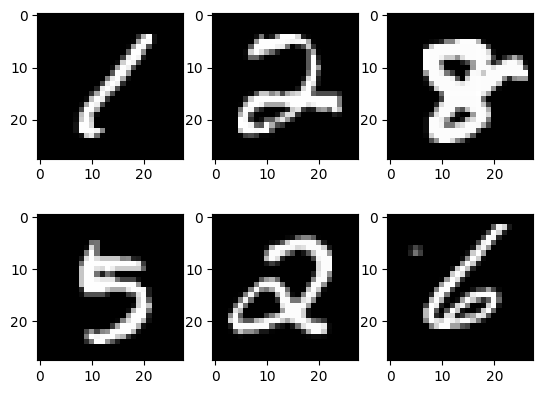

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Experiments with MNIST: $β$-Variational Autoencoder

### Experiments 1 : VAE with $\beta$ =0.02 with n_layer=1

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32, 64}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

## Test 1: $β$-VAE: BCE

### Experiment 3.1 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_1 = 'VAE'
model_config_4_1 = {'D_x': 784, 'n_layers': 1, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_1, fold_results_4_1 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_1),
                                                model_config=model_config_4_1,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:318.054753, Training Recons Loss: 303.210340, Training KLD Loss: 14.844412
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.06823904110871731, 'L1 Loss': 0.16590135623799993, 'BCE': 0.2751612547547259}, Validation VAE Loss: {'MSE': 231.81296506841133, 'L1 Loss': 231.56915948746052, 'BCE': 231.6563746675532}, Validation Recons Loss: {'MSE': 215.88301313684343, 'L1 Loss': 215.63920771822015, 'BCE': 215.72642289831282}, Validation KLD Loss: {'MSE': 15.929951890986016, 'L1 Loss': 15.929951890986016, 'BCE': 15.929951890986016}
Train Fold/Epoch: 1/2, Training Loss:223.470138, Training Recons Loss: 210.136285, Training KLD Loss: 13.333852
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.06453024211557622, 'L1 Loss': 0.154270109502559, 'BCE': 0.2610533554503258}, Validation VAE Loss: {'MSE': 2

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'
# Create the directory
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_1.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_1.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_1, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_1, f)


## Visualizing reconstructions for all fold

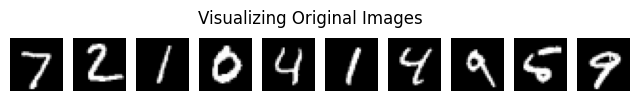

Visualizing reconstructions for fold 1


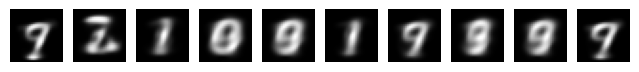

Visualizing reconstructions for fold 2


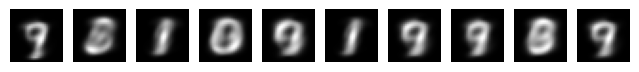

Visualizing reconstructions for fold 3


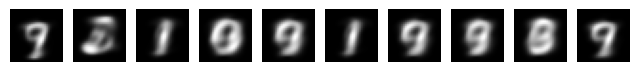

Visualizing reconstructions for fold 4


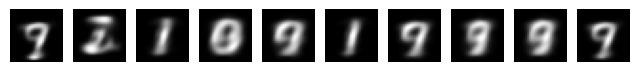

Visualizing reconstructions for fold 5


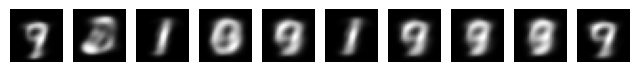

Visualizing reconstructions for fold 6


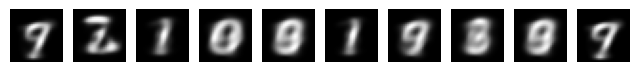

Visualizing reconstructions for fold 7


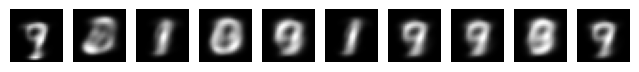

Visualizing reconstructions for fold 8


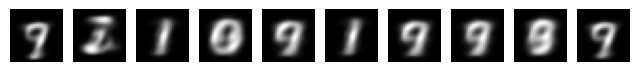

Visualizing reconstructions for fold 9


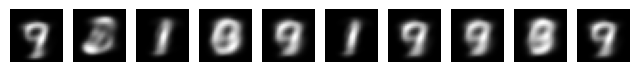

Visualizing reconstructions for fold 10


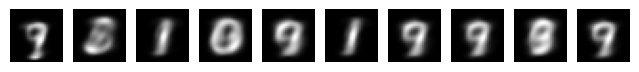

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_1.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_1 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_1):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

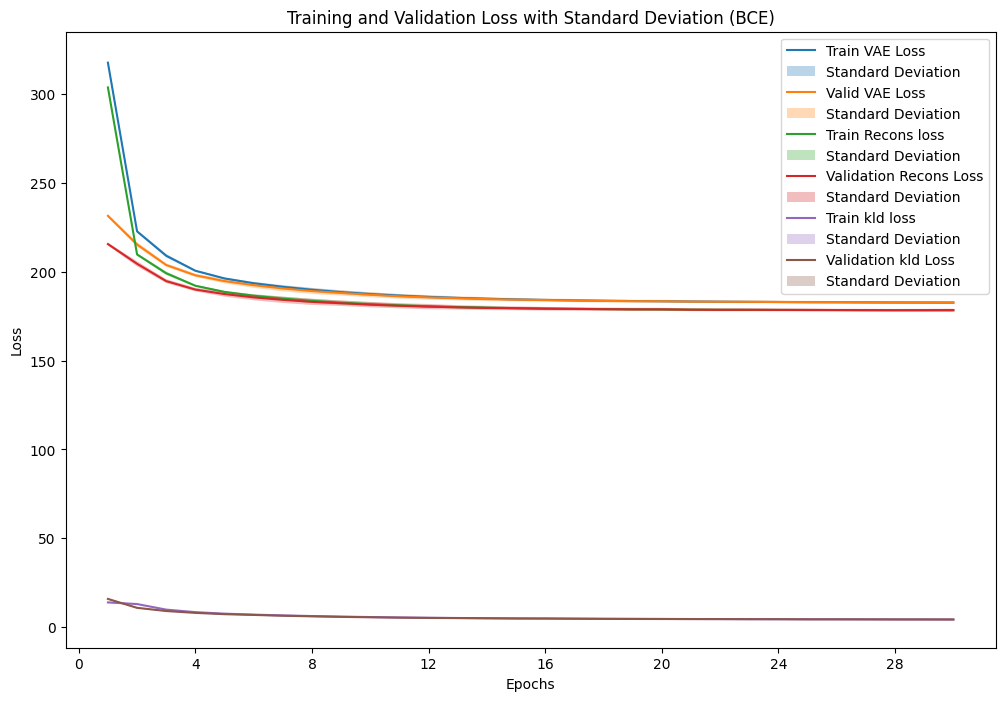

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_1 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_1_1 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_1_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_1['epochs'])
    VAE_plot_mean_std(result_data_4_1_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_1['epochs'])
    VAE_plot_mean_std(result_data_4_1_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_1['epochs'])
    VAE_plot_mean_std(result_data_4_1_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_1['epochs'])
    VAE_plot_mean_std(result_data_4_1_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_1['epochs'])
    VAE_plot_mean_std(result_data_4_1_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_1_1['valid_metrics'],
    result_data_4_1_1['test_metrics'],
    result_data_4_1_1['valid_result'],
    result_data_4_1_1['test_result'],
    result_data_4_1_1['recons_valid_result'],
    result_data_4_1_1['recons_test_result'],
    result_data_4_1_1['kld_valid_result'],
    result_data_4_1_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.227533           0.226507           182.685140     181.892573              178.385578        178.385578             4.299562       4.311309
Standard Deviation                 0.001056           0.000240             0.722862       0.139165                0.828268          0.828268             0.125940       0.124872

Detailed Evaluation Table:


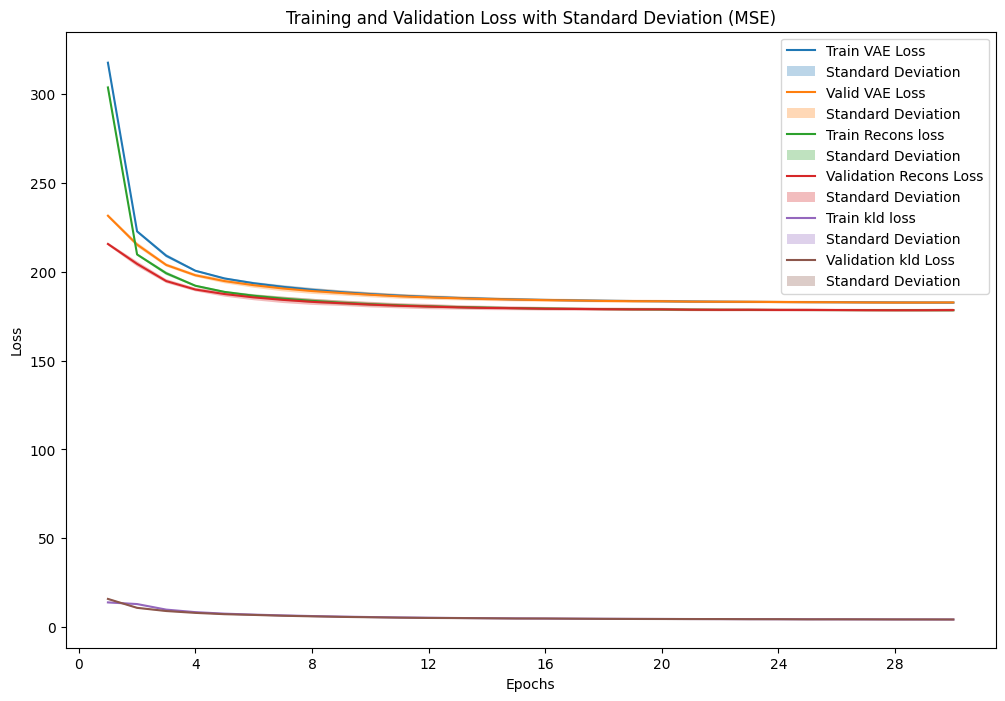

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_1 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_1_2 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_1_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_2['epochs'])
    VAE_plot_mean_std(result_data_4_1_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_2['epochs'])
    VAE_plot_mean_std(result_data_4_1_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_2['epochs'])
    VAE_plot_mean_std(result_data_4_1_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_2['epochs'])
    VAE_plot_mean_std(result_data_4_1_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_2['epochs'])
    VAE_plot_mean_std(result_data_4_1_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_1_2['valid_metrics'],
    result_data_4_1_2['test_metrics'],
    result_data_4_1_2['valid_result'],
    result_data_4_1_2['test_result'],
    result_data_4_1_2['recons_valid_result'],
    result_data_4_1_2['recons_test_result'],
    result_data_4_1_2['kld_valid_result'],
    result_data_4_1_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.056011           0.055805           182.669337     181.883438              178.369775        178.369775             4.299562       4.311309
Standard Deviation                 0.000277           0.000051             0.709671       0.134755                0.812740          0.812740             0.125940       0.124872

Detailed Evaluation Table:


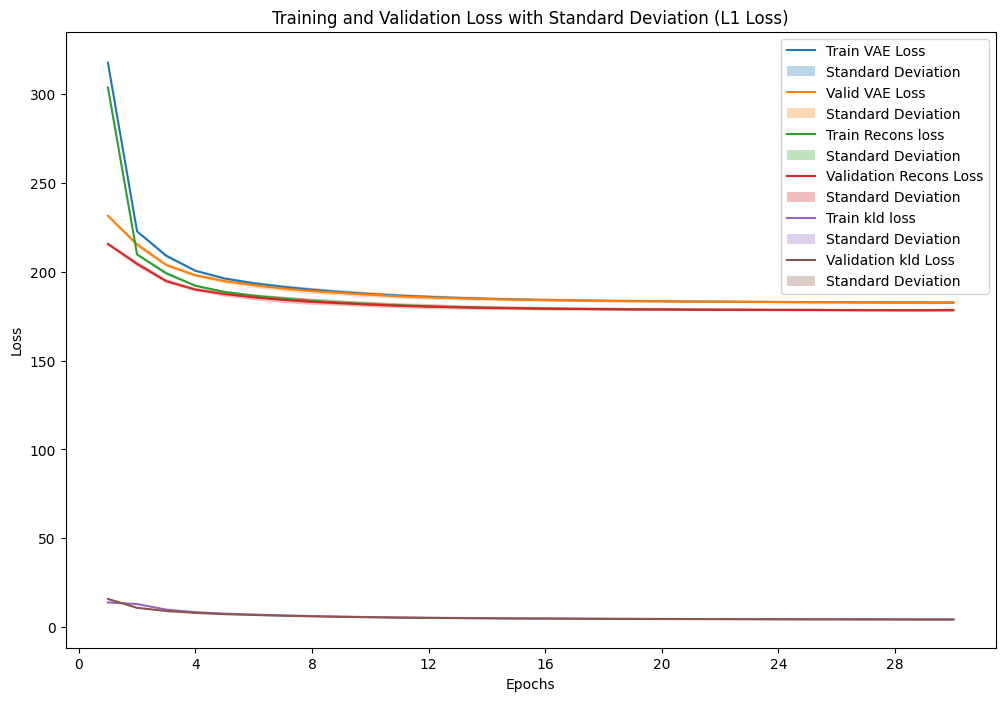

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_1 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_1_3 = VAE_plot_results(fold_results_4_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_1_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_1_3['epochs'])
    VAE_plot_mean_std(result_data_4_1_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_1_3['epochs'])
    VAE_plot_mean_std(result_data_4_1_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_1_3['epochs'])
    VAE_plot_mean_std(result_data_4_1_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_1_3['epochs'])
    VAE_plot_mean_std(result_data_4_1_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_1_3['epochs'])
    VAE_plot_mean_std(result_data_4_1_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_1_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_1_3['valid_metrics'],
    result_data_4_1_3['test_metrics'],
    result_data_4_1_3['valid_result'],
    result_data_4_1_3['test_result'],
    result_data_4_1_3['recons_valid_result'],
    result_data_4_1_3['recons_test_result'],
    result_data_4_1_3['kld_valid_result'],
    result_data_4_1_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.127180           0.127095           182.683611     181.885106              178.384048        178.384048             4.299562       4.311309
Standard Deviation                 0.001032           0.000761             0.711615       0.135074                0.814486          0.814486             0.125940       0.124872

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_1 = sum(p.numel() for p in models_4_1[0].parameters())
print(f"Number of parameters in the model: {total_params_4_1}")

Number of parameters in the model: 5492


### Latent Space Visualization

<ipython-input-9-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


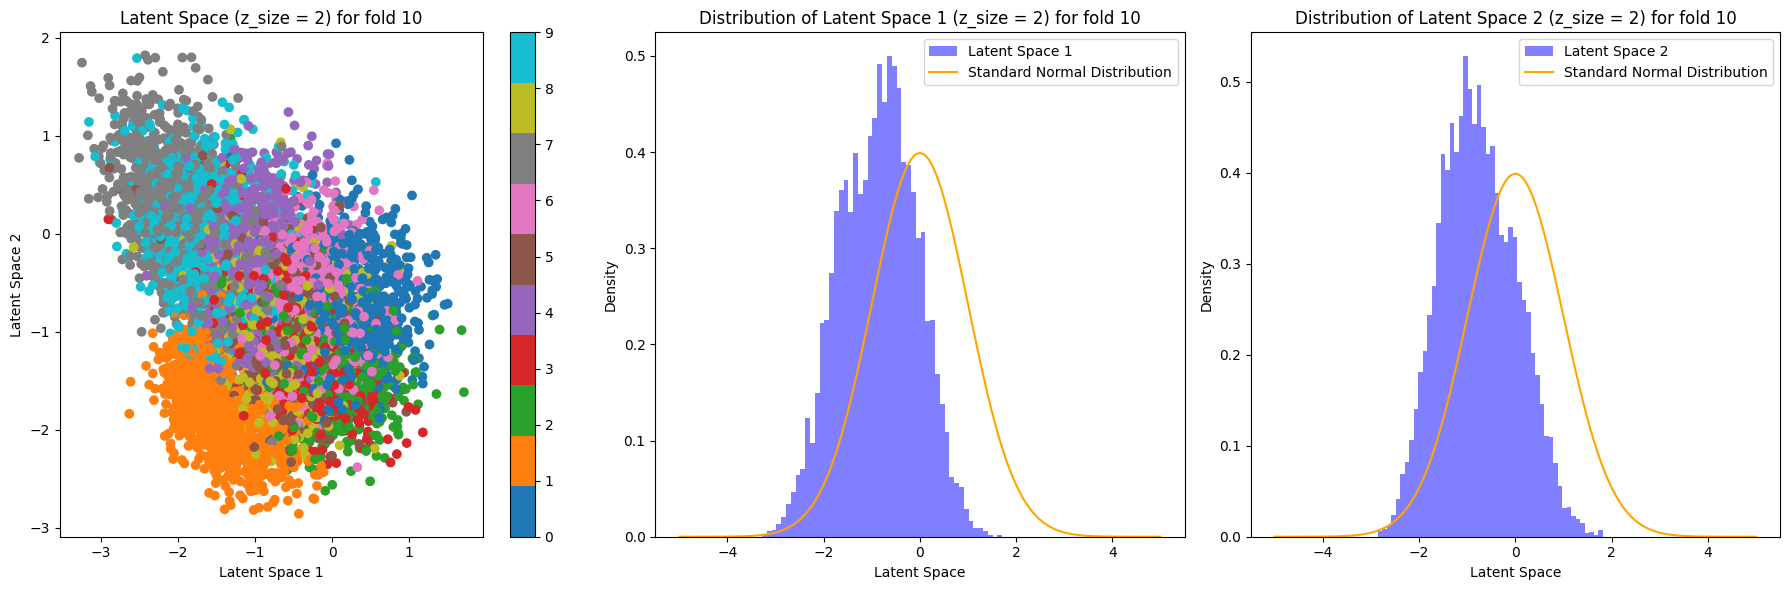

In [ ]:
latent_space_VAE_model(models_4_1[9], test_loader, device, number_fold=10)

### Sample new data using the decoder.

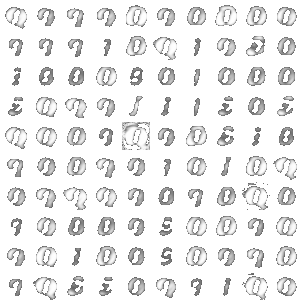

In [ ]:
sample(models_4_1[9],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

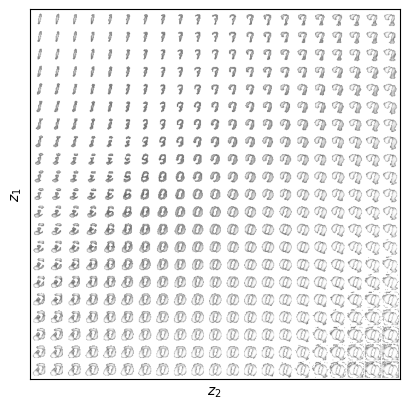

In [ ]:
VAE_visualize_latent_space(models_4_1[9], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 1 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_2 = 'VAE'
model_config_4_2 = {'D_x': 784, 'n_layers': 1, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_2, fold_results_4_2 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_2),
                                                model_config=model_config_4_2,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:230.745526, Training Recons Loss: 201.882535, Training KLD Loss: 28.862991
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.03773211136935873, 'L1 Loss': 0.10349823027215105, 'BCE': 0.18514979567299497}, Validation VAE Loss: {'MSE': 173.07800260503242, 'L1 Loss': 172.92399889357546, 'BCE': 172.91839664540393}, Validation Recons Loss: {'MSE': 145.3170454958652, 'L1 Loss': 145.16304227139088, 'BCE': 145.15744002321932}, Validation KLD Loss: {'MSE': 27.760956926548733, 'L1 Loss': 27.760956926548733, 'BCE': 27.760956926548733}
Train Fold/Epoch: 1/2, Training Loss:159.059758, Training Recons Loss: 131.994346, Training KLD Loss: 27.065412
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.029396848931433038, 'L1 Loss': 0.08463488582600938, 'BCE': 0.15827568588738747}, Validation VAE Loss: {'MS

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_2.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_2.pkl')

In [ ]:
# Save models_3_2
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_2, f)

# Save fold_results_3_2
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_2, f)


## Visualizing reconstructions for all fold

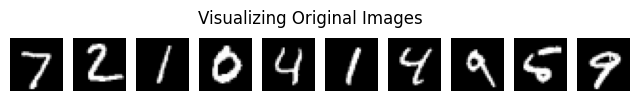

Visualizing reconstructions for fold 1


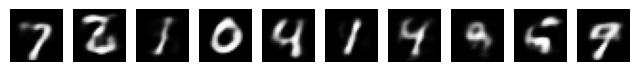

Visualizing reconstructions for fold 2


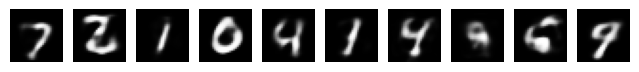

Visualizing reconstructions for fold 3


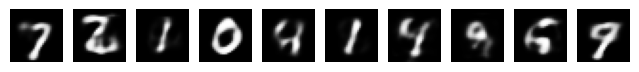

Visualizing reconstructions for fold 4


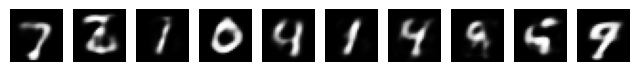

Visualizing reconstructions for fold 5


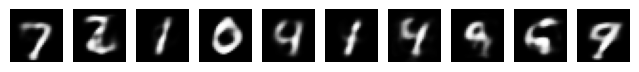

Visualizing reconstructions for fold 6


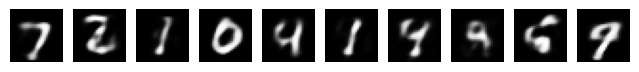

Visualizing reconstructions for fold 7


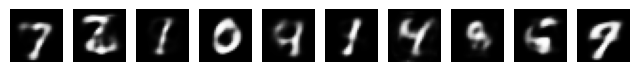

Visualizing reconstructions for fold 8


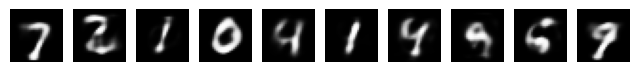

Visualizing reconstructions for fold 9


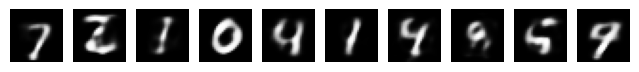

Visualizing reconstructions for fold 10


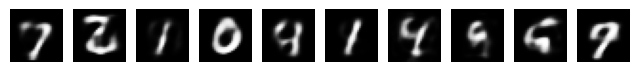

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_2.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_2 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_2):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

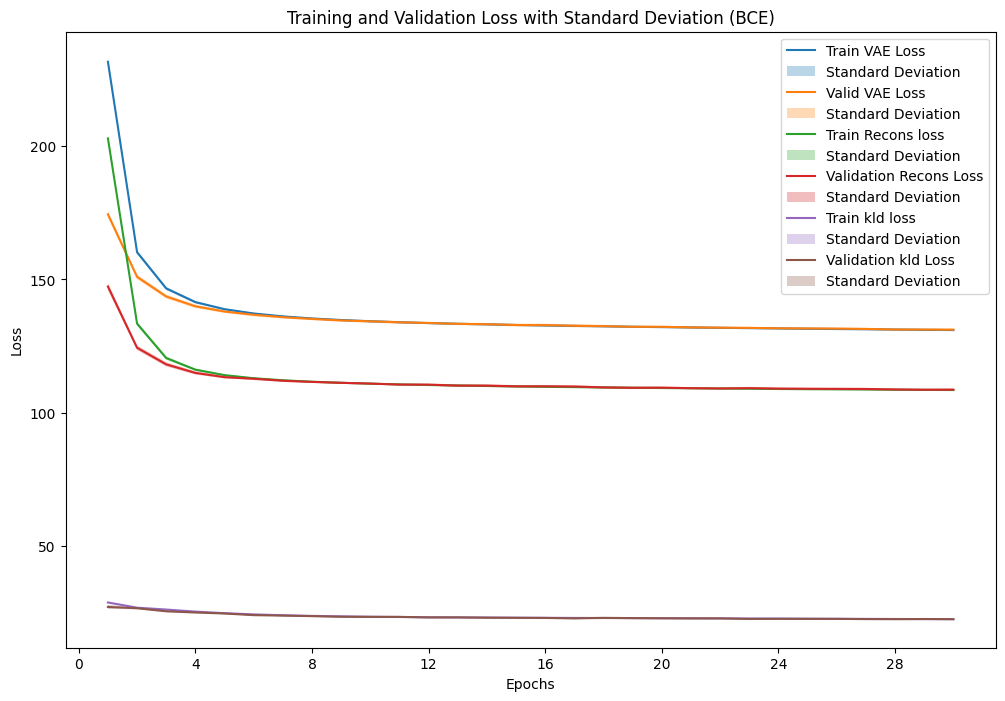

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_2 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_2_1 = VAE_plot_results(fold_results_4_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_2_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_2_1['epochs'])
    VAE_plot_mean_std(result_data_4_2_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_2_1['epochs'])
    VAE_plot_mean_std(result_data_4_2_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_2_1['epochs'])
    VAE_plot_mean_std(result_data_4_2_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_2_1['epochs'])
    VAE_plot_mean_std(result_data_4_2_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_2_1['epochs'])
    VAE_plot_mean_std(result_data_4_2_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_2_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_2_1['valid_metrics'],
    result_data_4_2_1['test_metrics'],
    result_data_4_2_1['valid_result'],
    result_data_4_2_1['test_result'],
    result_data_4_2_1['recons_valid_result'],
    result_data_4_2_1['recons_test_result'],
    result_data_4_2_1['kld_valid_result'],
    result_data_4_2_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.138679           0.136706           131.228546     129.779386              108.724453        108.724453            22.504094      22.601686
Standard Deviation                 0.000635           0.000310             0.505217       0.185018                0.498179          0.498179             0.196005       0.179022

Detailed Evaluation Table:


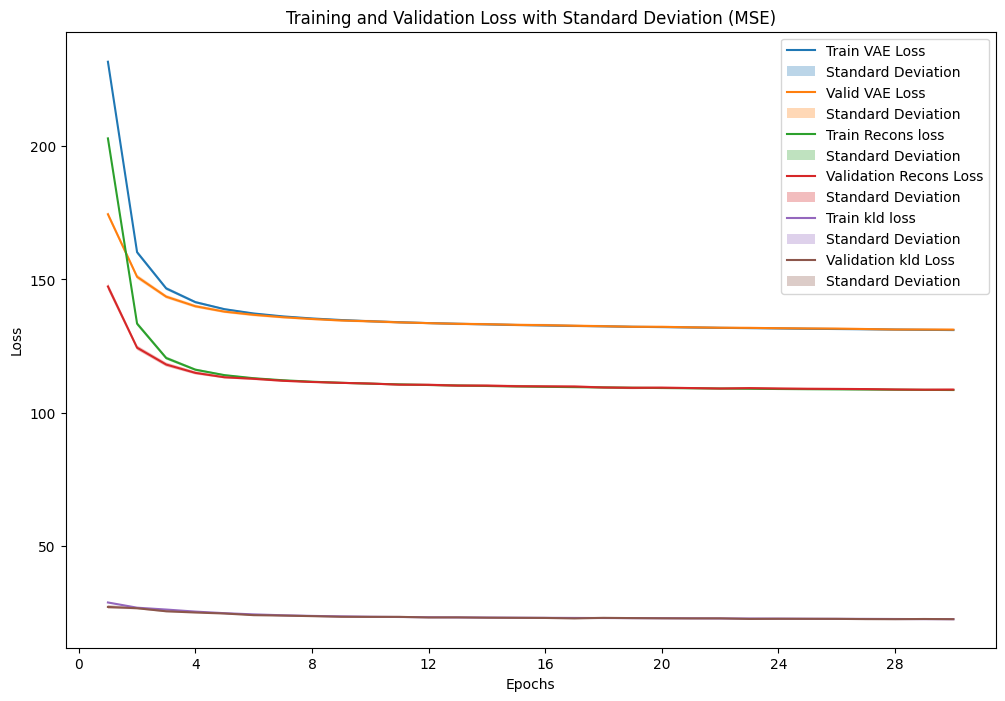

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_2 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_2_2 = VAE_plot_results(fold_results_4_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_2_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_2_2['epochs'])
    VAE_plot_mean_std(result_data_4_2_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_2_2['epochs'])
    VAE_plot_mean_std(result_data_4_2_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_2_2['epochs'])
    VAE_plot_mean_std(result_data_4_2_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_2_2['epochs'])
    VAE_plot_mean_std(result_data_4_2_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_2_2['epochs'])
    VAE_plot_mean_std(result_data_4_2_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_2_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_2_2['valid_metrics'],
    result_data_4_2_2['test_metrics'],
    result_data_4_2_2['valid_result'],
    result_data_4_2_2['test_result'],
    result_data_4_2_2['recons_valid_result'],
    result_data_4_2_2['recons_test_result'],
    result_data_4_2_2['kld_valid_result'],
    result_data_4_2_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.024833           0.024262           131.187393     129.756046              108.683299        108.683299            22.504094      22.601686
Standard Deviation                 0.000180           0.000119             0.472814       0.174482                0.477117          0.477117             0.196005       0.179022

Detailed Evaluation Table:


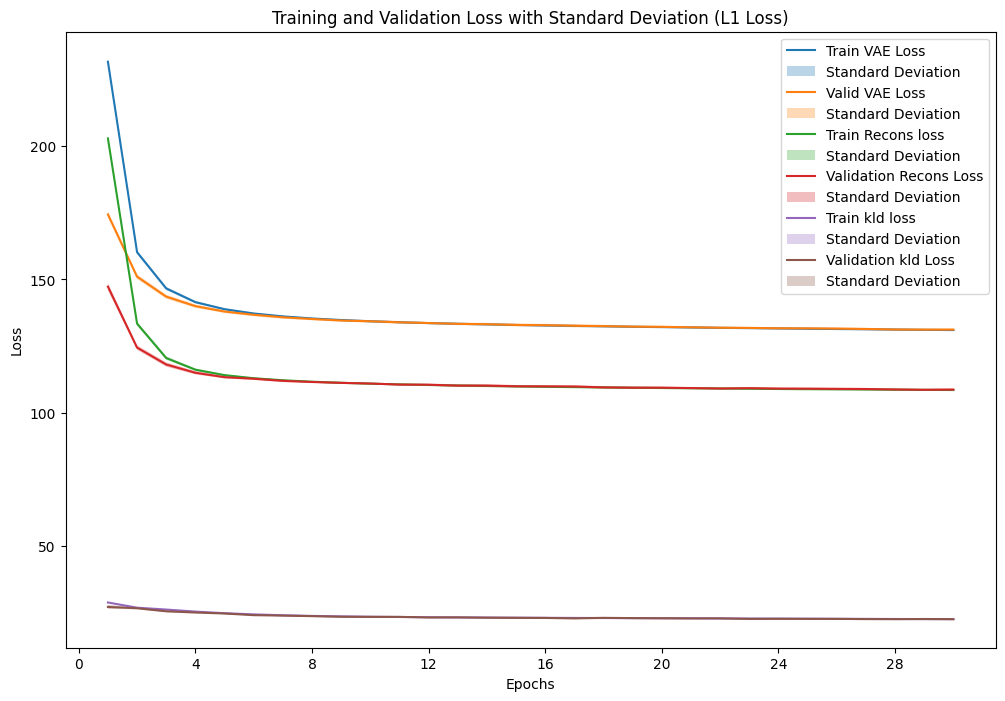

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_2 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_2_3 = VAE_plot_results(fold_results_4_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_2_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_2_3['epochs'])
    VAE_plot_mean_std(result_data_4_2_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_2_3['epochs'])
    VAE_plot_mean_std(result_data_4_2_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_2_3['epochs'])
    VAE_plot_mean_std(result_data_4_2_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_2_3['epochs'])
    VAE_plot_mean_std(result_data_4_2_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_2_3['epochs'])
    VAE_plot_mean_std(result_data_4_2_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_2_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_2_3['valid_metrics'],
    result_data_4_2_3['test_metrics'],
    result_data_4_2_3['valid_result'],
    result_data_4_2_3['test_result'],
    result_data_4_2_3['recons_valid_result'],
    result_data_4_2_3['recons_test_result'],
    result_data_4_2_3['kld_valid_result'],
    result_data_4_2_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                  0.06522           0.064257           131.162196     129.741671              108.658103        108.658103            22.504094      22.601686
Standard Deviation                  0.00034           0.000332             0.498175       0.153048                0.472932          0.472932             0.196005       0.179022

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_2 = sum(p.numel() for p in models_4_2[0].parameters())
print(f"Number of parameters in the model: {total_params_4_2}")

Number of parameters in the model: 38448


### Sample new data using the decoder.

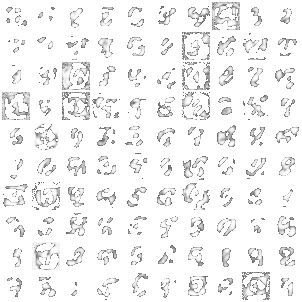

In [ ]:
sample(models_4_2[8],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_3 = 'VAE'
model_config_4_3 = {'D_x': 784, 'n_layers': 1, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_3, fold_results_4_3 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_3),
                                                model_config=model_config_4_3,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:212.440478, Training Recons Loss: 180.254867, Training KLD Loss: 32.185611
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.03181361541786092, 'L1 Loss': 0.09071117322495643, 'BCE': 0.1666810393650481}, Validation VAE Loss: {'MSE': 162.29778533286236, 'L1 Loss': 162.28693308728808, 'BCE': 162.29948457758476}, Validation Recons Loss: {'MSE': 130.67623422500935, 'L1 Loss': 130.66538197943504, 'BCE': 130.67793460602456}, Validation KLD Loss: {'MSE': 31.621550580288503, 'L1 Loss': 31.621550580288503, 'BCE': 31.621550580288503}
Train Fold/Epoch: 1/2, Training Loss:150.098904, Training Recons Loss: 117.200217, Training KLD Loss: 32.898687
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.022868934345055134, 'L1 Loss': 0.0690610427013103, 'BCE': 0.13749708972395736}, Validation VAE Loss: {'MSE

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_3.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_3.pkl')

In [ ]:
# Save models_3_3
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_3, f)

# Save fold_results_3_3
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_3, f)


## Visualizing reconstructions for all fold

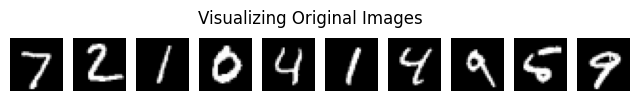

Visualizing reconstructions for fold 1


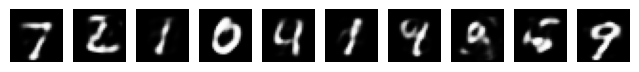

Visualizing reconstructions for fold 2


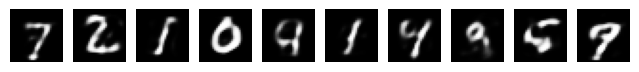

Visualizing reconstructions for fold 3


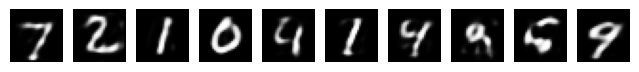

Visualizing reconstructions for fold 4


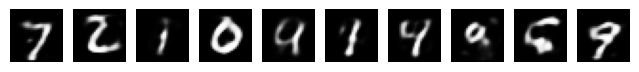

Visualizing reconstructions for fold 5


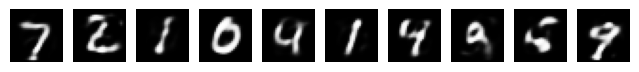

Visualizing reconstructions for fold 6


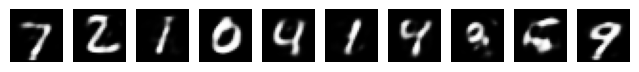

Visualizing reconstructions for fold 7


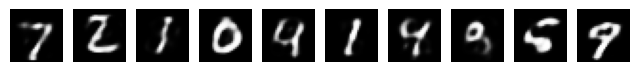

Visualizing reconstructions for fold 8


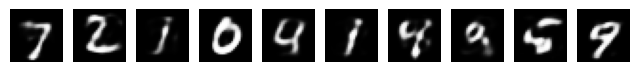

Visualizing reconstructions for fold 9


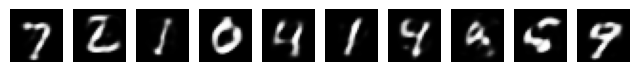

Visualizing reconstructions for fold 10


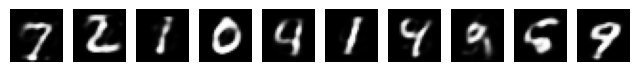

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_3.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_3 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_3):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

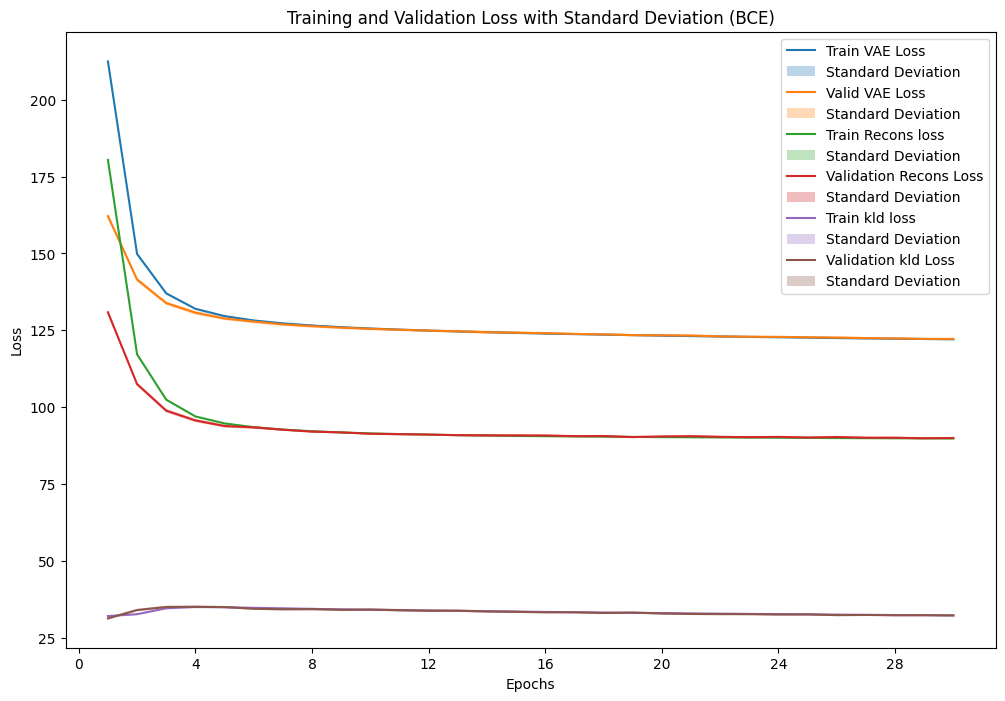

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_3 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_3_1 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_3_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_1['epochs'])
    VAE_plot_mean_std(result_data_4_3_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_1['epochs'])
    VAE_plot_mean_std(result_data_4_3_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_1['epochs'])
    VAE_plot_mean_std(result_data_4_3_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_1['epochs'])
    VAE_plot_mean_std(result_data_4_3_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_1['epochs'])
    VAE_plot_mean_std(result_data_4_3_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_3_1['valid_metrics'],
    result_data_4_3_1['test_metrics'],
    result_data_4_3_1['valid_result'],
    result_data_4_3_1['test_result'],
    result_data_4_3_1['recons_valid_result'],
    result_data_4_3_1['recons_test_result'],
    result_data_4_3_1['kld_valid_result'],
    result_data_4_3_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.114780           0.113015           122.223336     120.882072               89.987762         89.987762            32.235575      32.278678
Standard Deviation                 0.000327           0.000269             0.210713       0.127463                0.256660          0.256660             0.214375       0.179648

Detailed Evaluation Table:


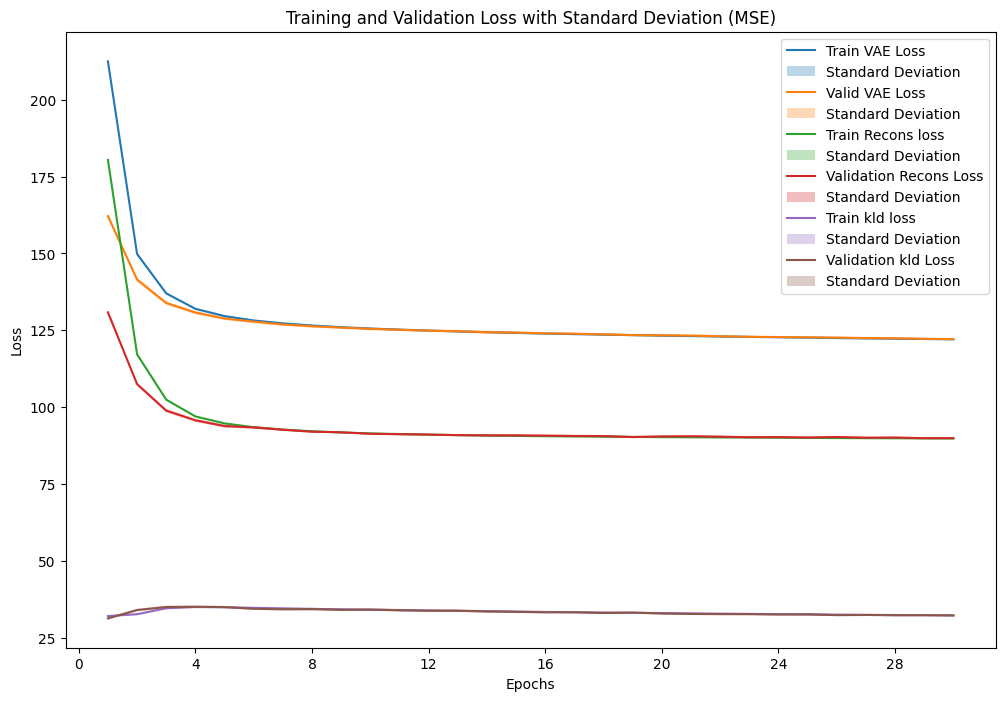

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_3 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_3_2 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_3_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_2['epochs'])
    VAE_plot_mean_std(result_data_4_3_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_2['epochs'])
    VAE_plot_mean_std(result_data_4_3_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_2['epochs'])
    VAE_plot_mean_std(result_data_4_3_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_2['epochs'])
    VAE_plot_mean_std(result_data_4_3_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_2['epochs'])
    VAE_plot_mean_std(result_data_4_3_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_3_2['valid_metrics'],
    result_data_4_3_2['test_metrics'],
    result_data_4_3_2['valid_result'],
    result_data_4_3_2['test_result'],
    result_data_4_3_2['recons_valid_result'],
    result_data_4_3_2['recons_test_result'],
    result_data_4_3_2['kld_valid_result'],
    result_data_4_3_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.016946           0.016440           122.241833     120.868506               90.006258         90.006258            32.235575      32.278678
Standard Deviation                 0.000077           0.000077             0.240185       0.100895                0.237373          0.237373             0.214375       0.179648

Detailed Evaluation Table:


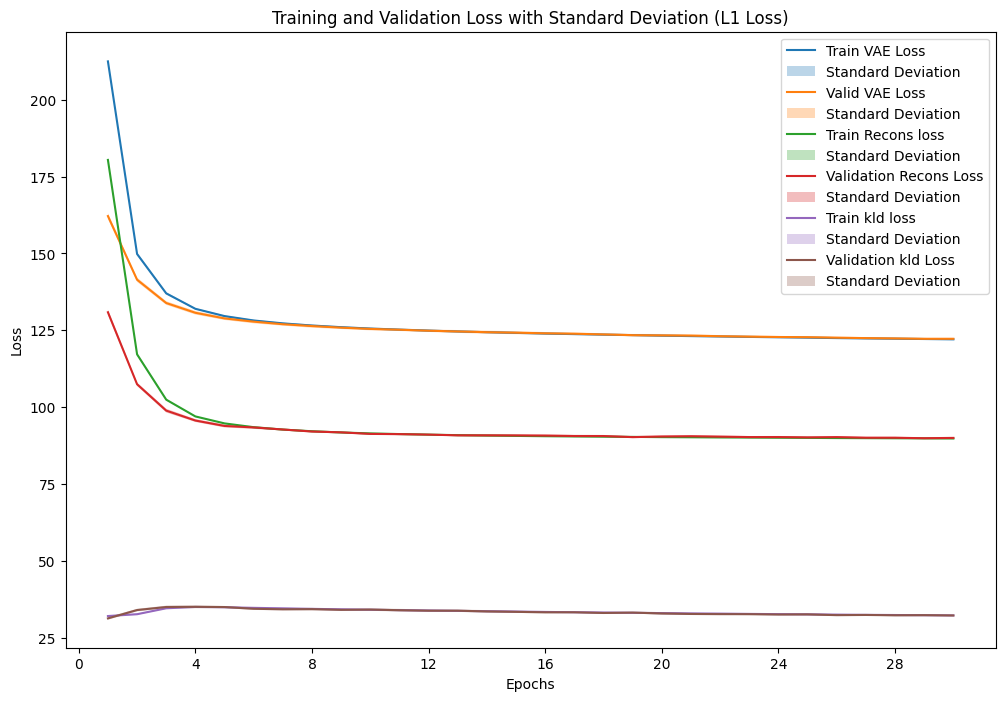

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_3 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_3_3 = VAE_plot_results(fold_results_4_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_3_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_3_3['epochs'])
    VAE_plot_mean_std(result_data_4_3_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_3_3['epochs'])
    VAE_plot_mean_std(result_data_4_3_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_3_3['epochs'])
    VAE_plot_mean_std(result_data_4_3_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_3_3['epochs'])
    VAE_plot_mean_std(result_data_4_3_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_3_3['epochs'])
    VAE_plot_mean_std(result_data_4_3_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_3_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_3_3['valid_metrics'],
    result_data_4_3_3['test_metrics'],
    result_data_4_3_3['valid_result'],
    result_data_4_3_3['test_result'],
    result_data_4_3_3['recons_valid_result'],
    result_data_4_3_3['recons_test_result'],
    result_data_4_3_3['kld_valid_result'],
    result_data_4_3_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.048967           0.048106           122.181461     120.877869               89.945886         89.945886            32.235575      32.278678
Standard Deviation                 0.000310           0.000289             0.252662       0.114120                0.240875          0.240875             0.214375       0.179648

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_3 = sum(p.numel() for p in models_4_3[0].parameters())
print(f"Number of parameters in the model: {total_params_4_3}")

Number of parameters in the model: 76112


### Sample new data using the decoder.

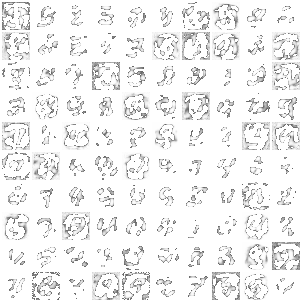

In [ ]:
sample(models_4_3[9],D_z=32)

### Experiment 3.4 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_4 = 'VAE'
model_config_4_4 = {'D_x': 784, 'n_layers': 1, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_4, fold_results_4_4 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_4),
                                                model_config=model_config_4_4,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:199.994567, Training Recons Loss: 166.127836, Training KLD Loss: 33.866731
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.029200475484608336, 'L1 Loss': 0.08351499341586803, 'BCE': 0.15730166308423307}, Validation VAE Loss: {'MSE': 157.16253061497466, 'L1 Loss': 156.99234641866482, 'BCE': 156.97746406717502}, Validation Recons Loss: {'MSE': 123.50957034496551, 'L1 Loss': 123.33938598632812, 'BCE': 123.3245043653123}, Validation KLD Loss: {'MSE': 33.65295986419029, 'L1 Loss': 33.65295986419029, 'BCE': 33.65295986419029}
Train Fold/Epoch: 1/2, Training Loss:148.564784, Training Recons Loss: 112.604650, Training KLD Loss: 35.960134
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.022099955245218378, 'L1 Loss': 0.06610732925857635, 'BCE': 0.13466464387292557}, Validation VAE Loss: {'MSE'

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_4.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_4.pkl')

In [ ]:
# Save models_3_4
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_4, f)

# Save fold_results_3_4
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_4, f)


## Visualizing reconstructions for all fold

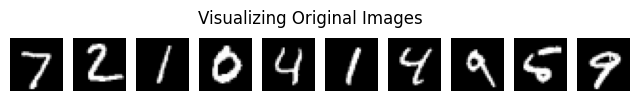

Visualizing reconstructions for fold 1


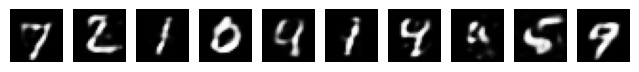

Visualizing reconstructions for fold 2


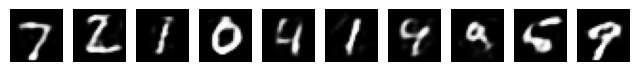

Visualizing reconstructions for fold 3


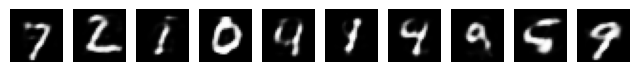

Visualizing reconstructions for fold 4


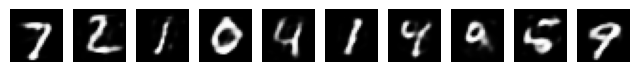

Visualizing reconstructions for fold 5


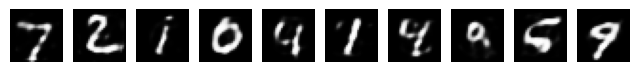

Visualizing reconstructions for fold 6


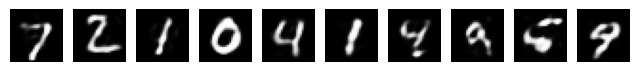

Visualizing reconstructions for fold 7


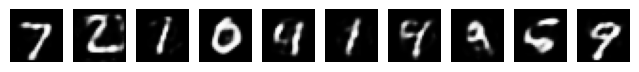

Visualizing reconstructions for fold 8


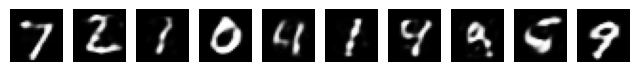

Visualizing reconstructions for fold 9


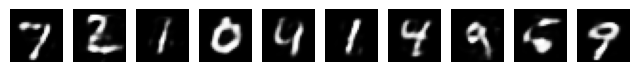

Visualizing reconstructions for fold 10


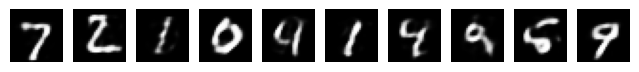

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_4.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_4 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_4):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

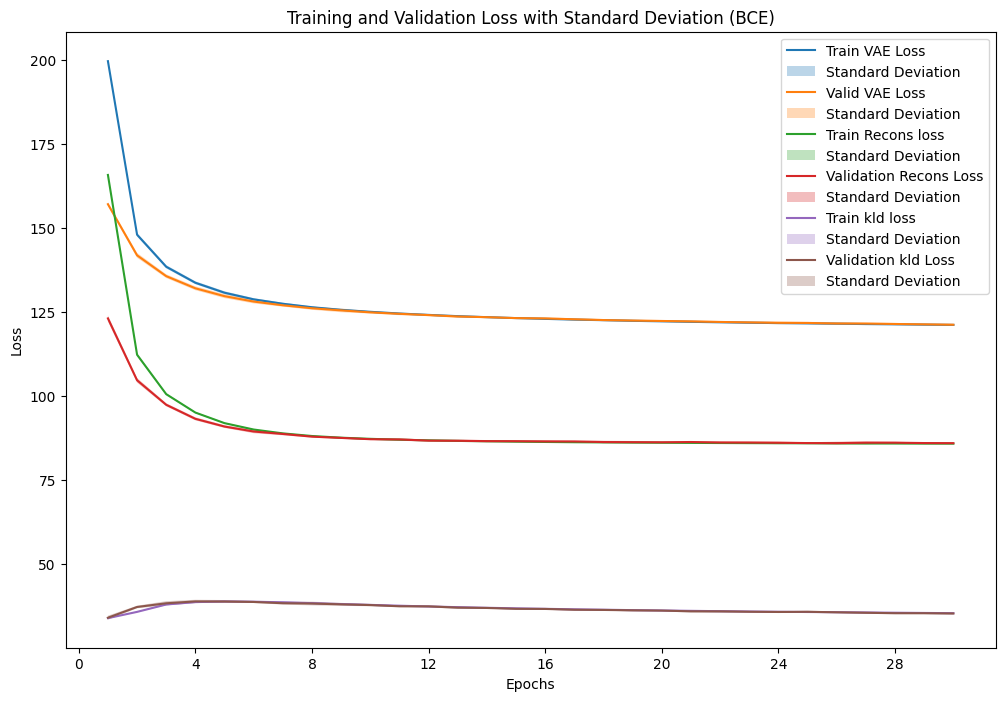

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_4 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_4_1 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_4_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_1['epochs'])
    VAE_plot_mean_std(result_data_4_4_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_1['epochs'])
    VAE_plot_mean_std(result_data_4_4_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_1['epochs'])
    VAE_plot_mean_std(result_data_4_4_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_1['epochs'])
    VAE_plot_mean_std(result_data_4_4_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_1['epochs'])
    VAE_plot_mean_std(result_data_4_4_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_4_1['valid_metrics'],
    result_data_4_4_1['test_metrics'],
    result_data_4_4_1['valid_result'],
    result_data_4_4_1['test_result'],
    result_data_4_4_1['recons_valid_result'],
    result_data_4_4_1['recons_test_result'],
    result_data_4_4_1['kld_valid_result'],
    result_data_4_4_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.109693           0.108144           121.224866     119.950586               85.999156         85.999156            35.225711      35.166055
Standard Deviation                 0.000391           0.000367             0.316776       0.110422                0.306884          0.306884             0.287013       0.274328

Detailed Evaluation Table:


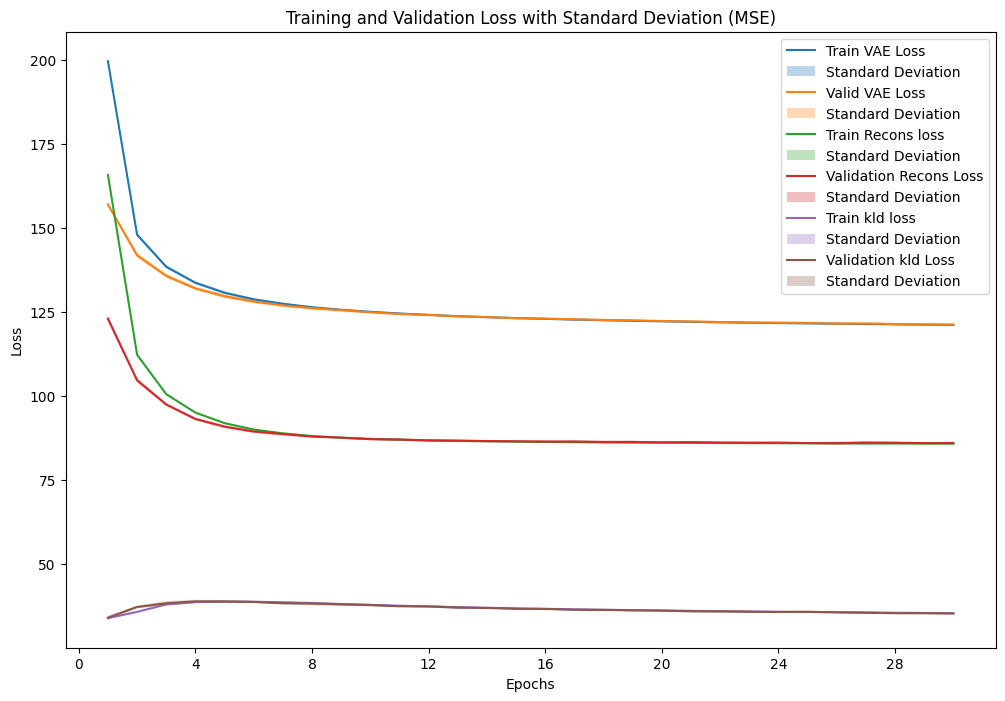

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_4 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_4_2 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_4_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_2['epochs'])
    VAE_plot_mean_std(result_data_4_4_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_2['epochs'])
    VAE_plot_mean_std(result_data_4_4_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_2['epochs'])
    VAE_plot_mean_std(result_data_4_4_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_2['epochs'])
    VAE_plot_mean_std(result_data_4_4_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_2['epochs'])
    VAE_plot_mean_std(result_data_4_4_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_4_2['valid_metrics'],
    result_data_4_4_2['test_metrics'],
    result_data_4_4_2['valid_result'],
    result_data_4_4_2['test_result'],
    result_data_4_4_2['recons_valid_result'],
    result_data_4_4_2['recons_test_result'],
    result_data_4_4_2['kld_valid_result'],
    result_data_4_4_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.015199           0.014766           121.182617     119.881116               85.956906         85.956906            35.225711      35.166055
Standard Deviation                 0.000109           0.000109             0.303122       0.125134                0.287242          0.287242             0.287013       0.274328

Detailed Evaluation Table:


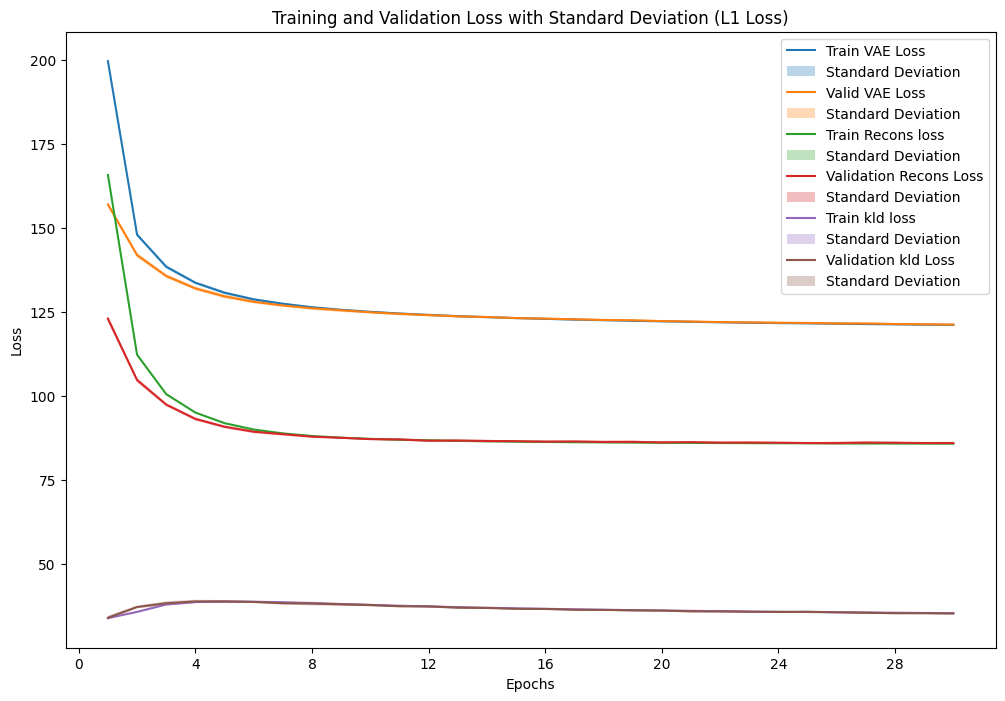

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_4 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_4_3 = VAE_plot_results(fold_results_4_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_4_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_4_3['epochs'])
    VAE_plot_mean_std(result_data_4_4_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_4_3['epochs'])
    VAE_plot_mean_std(result_data_4_4_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_4_3['epochs'])
    VAE_plot_mean_std(result_data_4_4_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_4_3['epochs'])
    VAE_plot_mean_std(result_data_4_4_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_4_3['epochs'])
    VAE_plot_mean_std(result_data_4_4_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_4_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_4_3['valid_metrics'],
    result_data_4_4_3['test_metrics'],
    result_data_4_4_3['valid_result'],
    result_data_4_4_3['test_result'],
    result_data_4_4_3['recons_valid_result'],
    result_data_4_4_3['recons_test_result'],
    result_data_4_4_3['kld_valid_result'],
    result_data_4_4_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.045498           0.044742           121.176098     119.927555               85.950388         85.950388            35.225711      35.166055
Standard Deviation                 0.000224           0.000241             0.247661       0.137962                0.250498          0.250498             0.287013       0.274328

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_4 = sum(p.numel() for p in models_4_4[0].parameters())
print(f"Number of parameters in the model: {total_params_4_4}")

Number of parameters in the model: 151440


### Sample new data using the decoder.

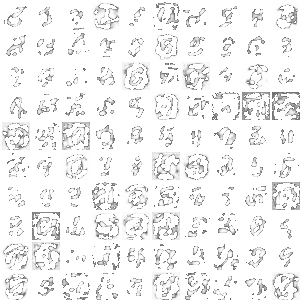

In [ ]:
sample(models_4_4[8],D_z=64)

## Test 2 VAE: BCE

### Experiments 2 : VAE with $\beta$ =0.02 with n_layer =2

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

### Experiment 3.1 : VAE with 2 layer

- Model: VAE of 2 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_6 = 'VAE'
model_config_4_6 = {'D_x': 784, 'n_layers': 2, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_6, fold_results_4_6 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_6),
                                                model_config=model_config_4_6,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:183.041961, Training Recons Loss: 177.831814, Training KLD Loss: 5.210147
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.04985865899064439, 'L1 Loss': 0.1156283697073764, 'BCE': 0.20850549004179367}, Validation VAE Loss: {'MSE': 168.3916109774975, 'L1 Loss': 168.37564021983044, 'BCE': 168.34027846316073}, Validation Recons Loss: {'MSE': 163.51963724988573, 'L1 Loss': 163.5036666545462, 'BCE': 163.4683048978765}, Validation KLD Loss: {'MSE': 4.87197305801067, 'L1 Loss': 4.87197305801067, 'BCE': 4.87197305801067}
Train Fold/Epoch: 1/2, Training Loss:165.023776, Training Recons Loss: 159.907110, Training KLD Loss: 5.116666
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.04705386462205268, 'L1 Loss': 0.11037248594963804, 'BCE': 0.2008462870057593}, Validation VAE Loss: {'MSE': 162.60527

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_6.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_6.pkl')

In [ ]:
# Save models_4_6
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_6, f)

# Save fold_results_4_6
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_6, f)


## Visualizing reconstructions for all fold

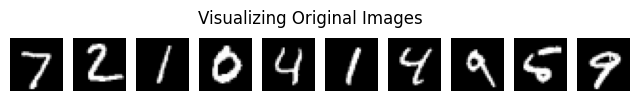

Visualizing reconstructions for fold 1


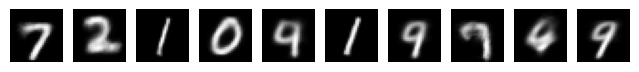

Visualizing reconstructions for fold 2


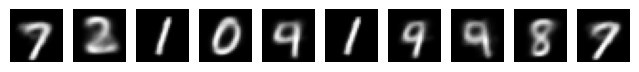

Visualizing reconstructions for fold 3


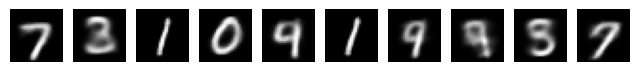

Visualizing reconstructions for fold 4


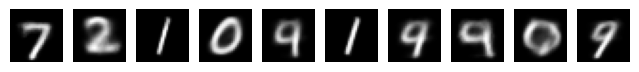

Visualizing reconstructions for fold 5


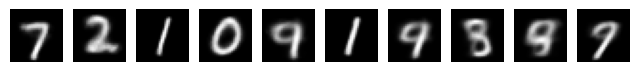

Visualizing reconstructions for fold 6


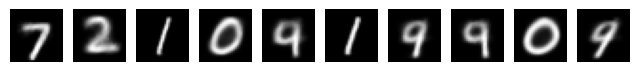

Visualizing reconstructions for fold 7


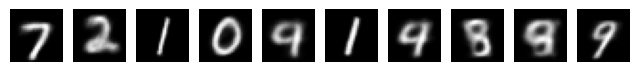

Visualizing reconstructions for fold 8


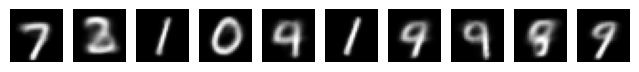

Visualizing reconstructions for fold 9


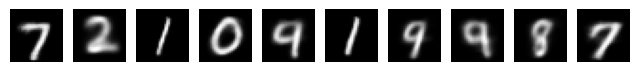

Visualizing reconstructions for fold 10


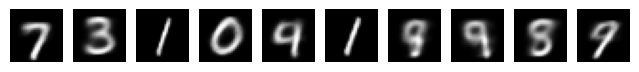

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_6.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_6 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_6):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

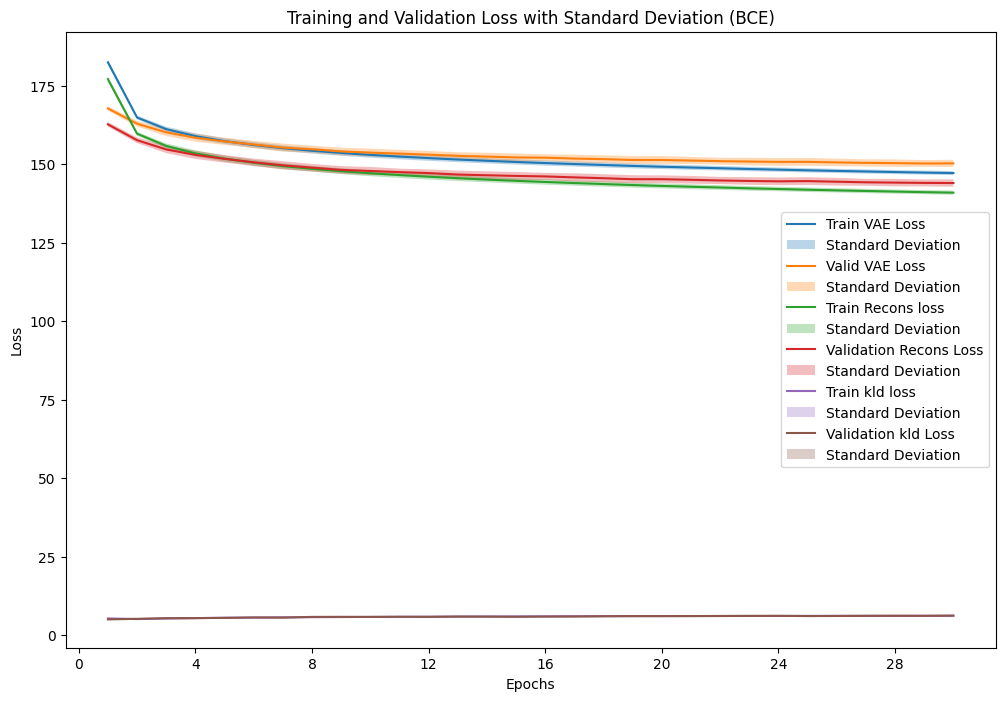

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_6 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_6_1 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_6_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_1['epochs'])
    VAE_plot_mean_std(result_data_4_6_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_1['epochs'])
    VAE_plot_mean_std(result_data_4_6_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_1['epochs'])
    VAE_plot_mean_std(result_data_4_6_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_1['epochs'])
    VAE_plot_mean_std(result_data_4_6_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_1['epochs'])
    VAE_plot_mean_std(result_data_4_6_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_6_1['valid_metrics'],
    result_data_4_6_1['test_metrics'],
    result_data_4_6_1['valid_result'],
    result_data_4_6_1['test_result'],
    result_data_4_6_1['recons_valid_result'],
    result_data_4_6_1['recons_test_result'],
    result_data_4_6_1['kld_valid_result'],
    result_data_4_6_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.183637           0.183448           150.221329     150.050493              143.971144        143.971144             6.250185       6.226949
Standard Deviation                 0.001529           0.001187             1.171587       0.966710                1.198610          1.198610             0.145799       0.152433

Detailed Evaluation Table:


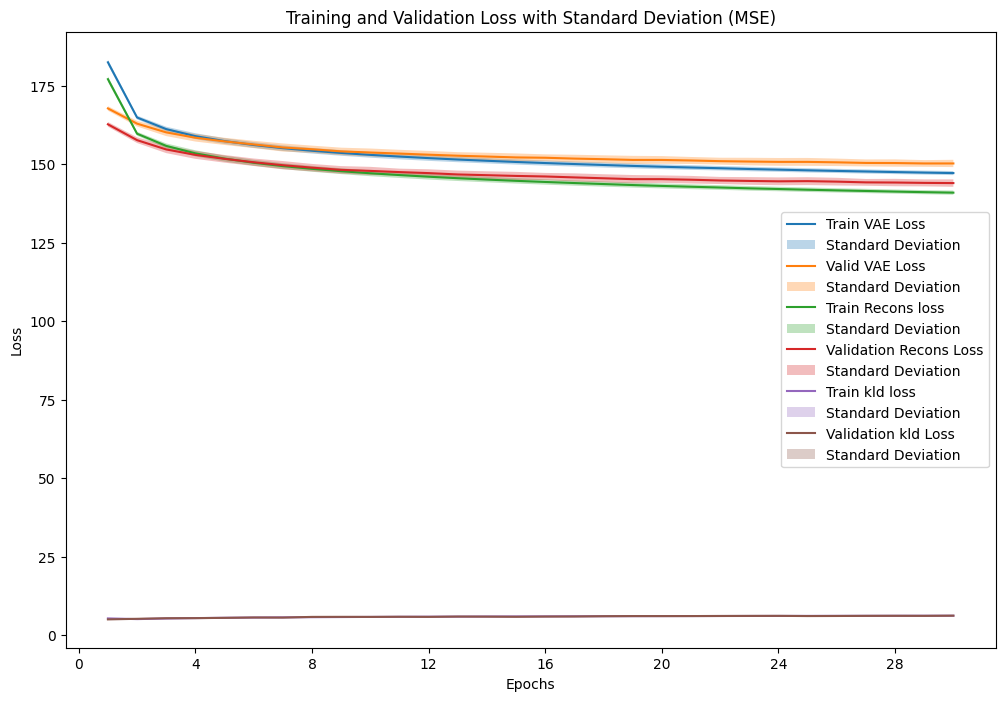

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_6 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_6_2 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_6_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_2['epochs'])
    VAE_plot_mean_std(result_data_4_6_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_2['epochs'])
    VAE_plot_mean_std(result_data_4_6_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_2['epochs'])
    VAE_plot_mean_std(result_data_4_6_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_2['epochs'])
    VAE_plot_mean_std(result_data_4_6_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_2['epochs'])
    VAE_plot_mean_std(result_data_4_6_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_6_2['valid_metrics'],
    result_data_4_6_2['test_metrics'],
    result_data_4_6_2['valid_result'],
    result_data_4_6_2['test_result'],
    result_data_4_6_2['recons_valid_result'],
    result_data_4_6_2['recons_test_result'],
    result_data_4_6_2['kld_valid_result'],
    result_data_4_6_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.041075           0.041091           150.261359     150.046894              144.011173        144.011173             6.250185       6.226949
Standard Deviation                 0.000547           0.000513             1.201884       0.982822                1.226721          1.226721             0.145799       0.152433

Detailed Evaluation Table:


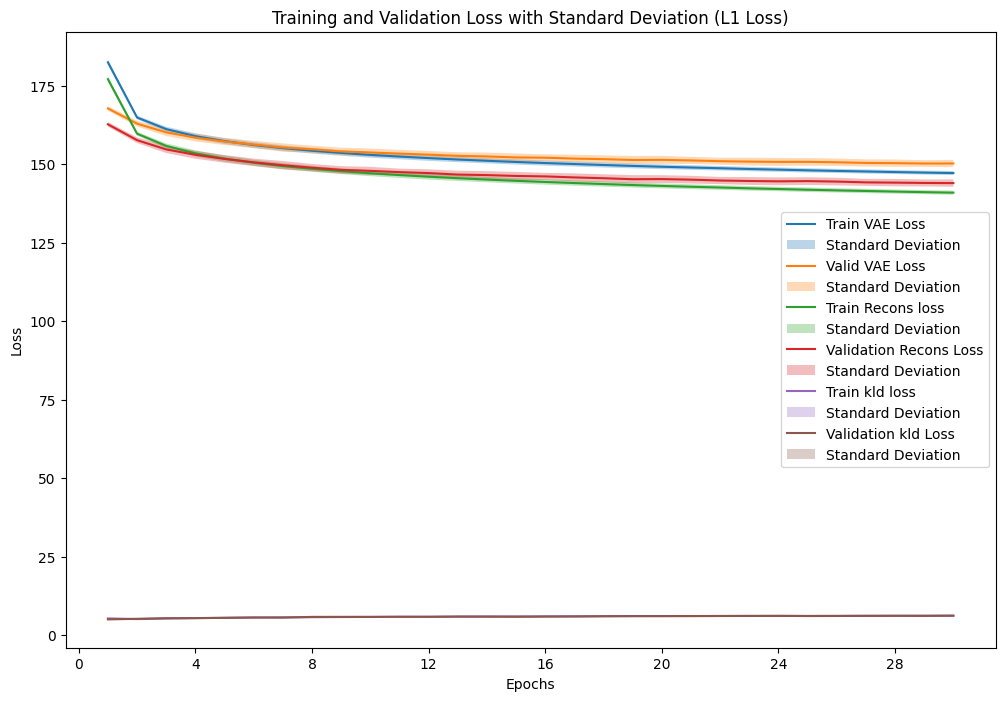

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_6 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_6_3 = VAE_plot_results(fold_results_4_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_6_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_6_3['epochs'])
    VAE_plot_mean_std(result_data_4_6_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_6_3['epochs'])
    VAE_plot_mean_std(result_data_4_6_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_6_3['epochs'])
    VAE_plot_mean_std(result_data_4_6_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_6_3['epochs'])
    VAE_plot_mean_std(result_data_4_6_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_6_3['epochs'])
    VAE_plot_mean_std(result_data_4_6_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_6_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_6_3['valid_metrics'],
    result_data_4_6_3['test_metrics'],
    result_data_4_6_3['valid_result'],
    result_data_4_6_3['test_result'],
    result_data_4_6_3['recons_valid_result'],
    result_data_4_6_3['recons_test_result'],
    result_data_4_6_3['kld_valid_result'],
    result_data_4_6_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.096430           0.096547           150.235933     150.042607              143.985748        143.985748             6.250185       6.226949
Standard Deviation                 0.000969           0.000872             1.145012       0.943424                1.168446          1.168446             0.145799       0.152433

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_6 = sum(p.numel() for p in models_4_6[0].parameters())
print(f"Number of parameters in the model: {total_params_4_6}")

Number of parameters in the model: 620156


<ipython-input-9-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


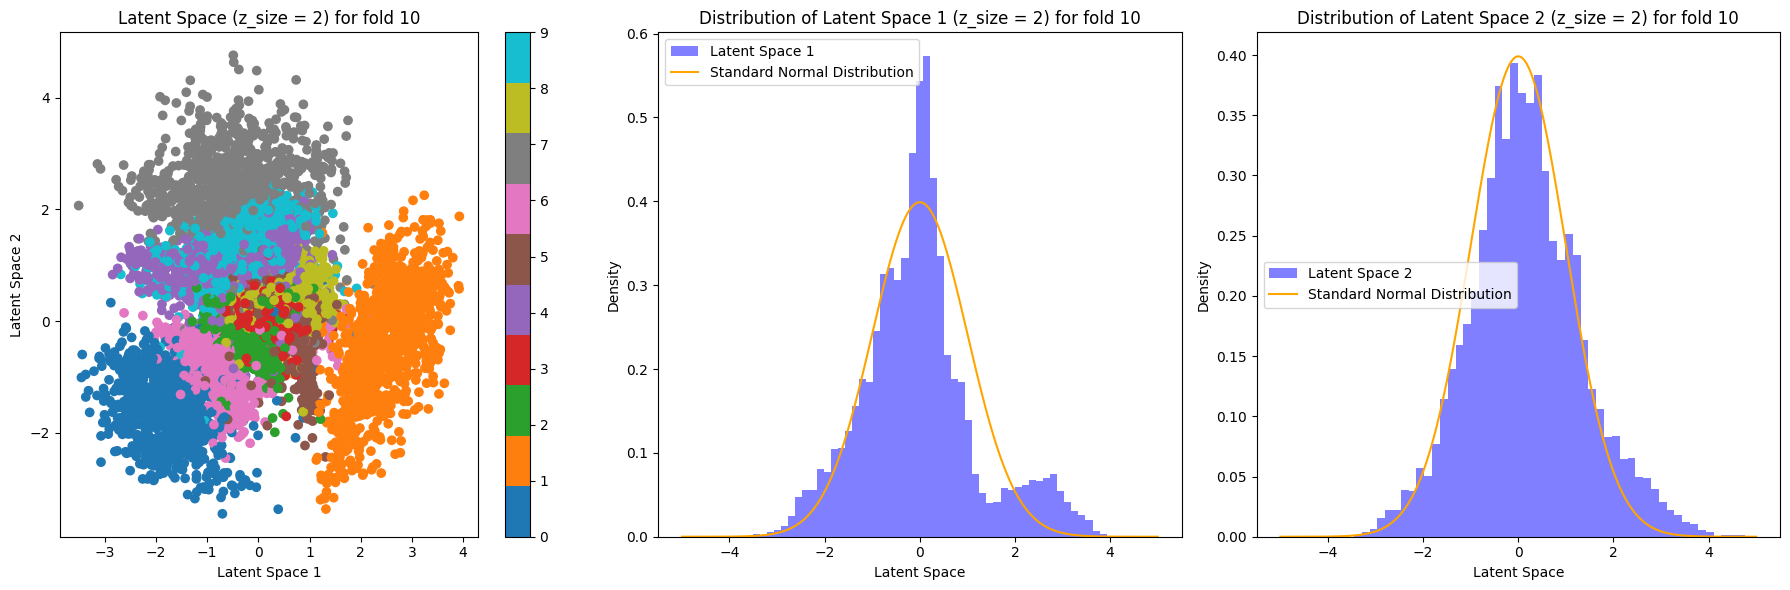

In [ ]:
latent_space_VAE_model(models_4_6[9], test_loader, device, number_fold=10)

### Sample new data using the decoder.

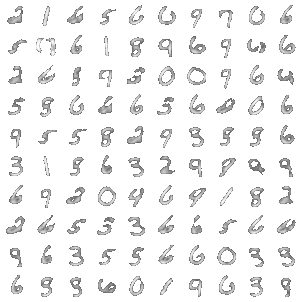

In [ ]:
sample(models_4_6[9],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

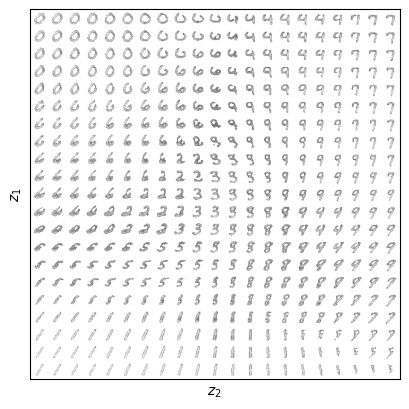

In [ ]:
VAE_visualize_latent_space(models_4_6[9], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_7 = 'VAE'
model_config_4_7 = {'D_x': 784, 'n_layers': 2, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_7, fold_results_4_7 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_7),
                                                model_config=model_config_4_7,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:148.828876, Training Recons Loss: 131.876808, Training KLD Loss: 16.952068
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.021953129863485375, 'L1 Loss': 0.05995658769252452, 'BCE': 0.12923146863567067}, Validation VAE Loss: {'MSE': 121.71003236161901, 'L1 Loss': 121.62815329369079, 'BCE': 121.64545830259932}, Validation Recons Loss: {'MSE': 101.38204469072058, 'L1 Loss': 101.30016562279235, 'BCE': 101.3174708751922}, Validation KLD Loss: {'MSE': 20.327987447698067, 'L1 Loss': 20.327987447698067, 'BCE': 20.327987447698067}
Train Fold/Epoch: 1/2, Training Loss:116.967116, Training Recons Loss: 95.267239, Training KLD Loss: 21.699877
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.018259513162155735, 'L1 Loss': 0.05210688682471184, 'BCE': 0.11766956738652067}, Validation VAE Loss: {'MS

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_7.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_7.pkl')

In [ ]:
# Save models_4_7
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_7, f)

# Save fold_results_4_7
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_7, f)


## Visualizing reconstructions for all fold

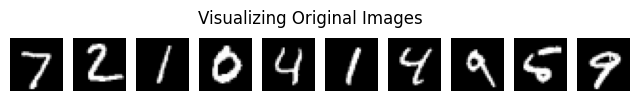

Visualizing reconstructions for fold 1


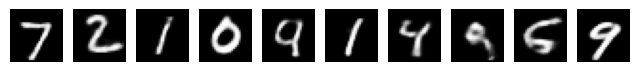

Visualizing reconstructions for fold 2


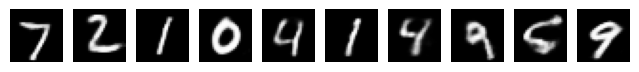

Visualizing reconstructions for fold 3


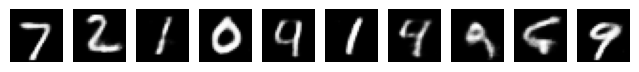

Visualizing reconstructions for fold 4


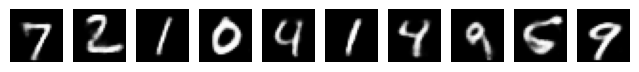

Visualizing reconstructions for fold 5


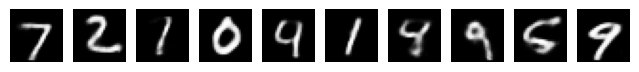

Visualizing reconstructions for fold 6


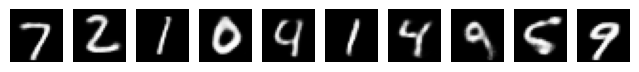

Visualizing reconstructions for fold 7


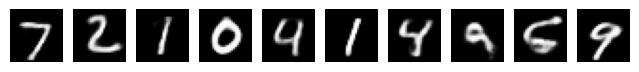

Visualizing reconstructions for fold 8


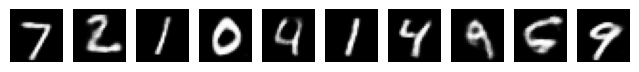

Visualizing reconstructions for fold 9


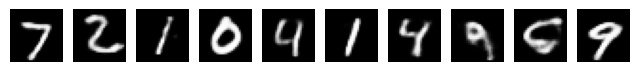

Visualizing reconstructions for fold 10


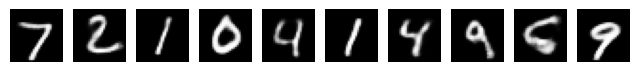

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_7.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_7 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_7):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

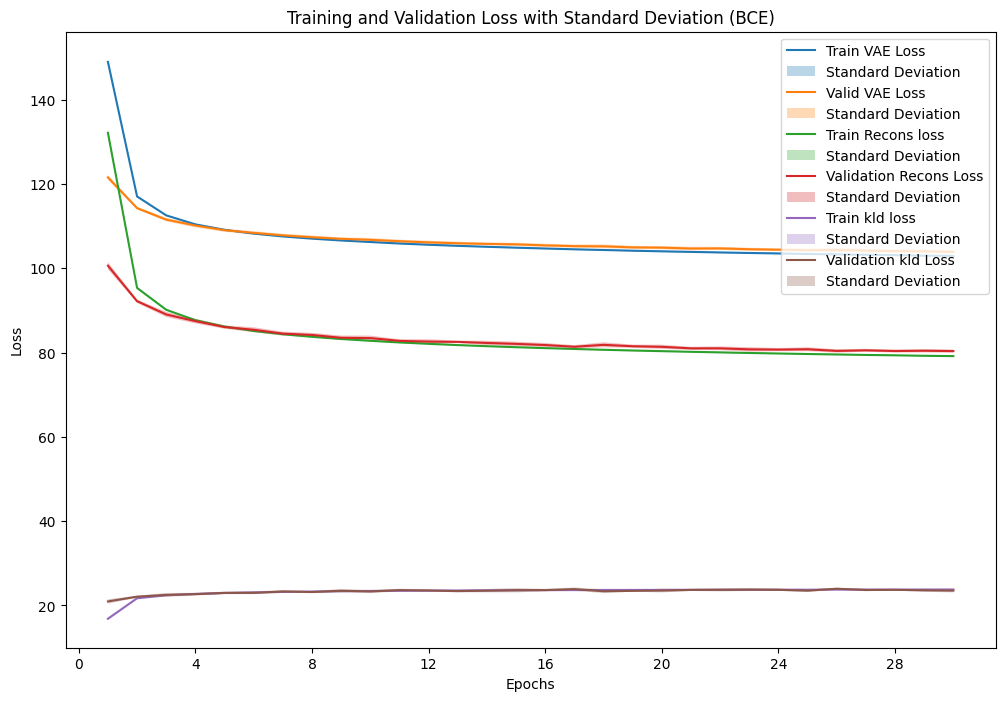

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_7 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_7_1 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_7_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_1['epochs'])
    VAE_plot_mean_std(result_data_4_7_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_1['epochs'])
    VAE_plot_mean_std(result_data_4_7_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_1['epochs'])
    VAE_plot_mean_std(result_data_4_7_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_1['epochs'])
    VAE_plot_mean_std(result_data_4_7_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_1['epochs'])
    VAE_plot_mean_std(result_data_4_7_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_7_1['valid_metrics'],
    result_data_4_7_1['test_metrics'],
    result_data_4_7_1['valid_result'],
    result_data_4_7_1['test_result'],
    result_data_4_7_1['recons_valid_result'],
    result_data_4_7_1['recons_test_result'],
    result_data_4_7_1['kld_valid_result'],
    result_data_4_7_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.102527           0.101430           103.910132     103.043681               80.381220         80.381220            23.528913      23.522442
Standard Deviation                 0.000414           0.000506             0.276667       0.224227                0.324421          0.324421             0.423826       0.414715

Detailed Evaluation Table:


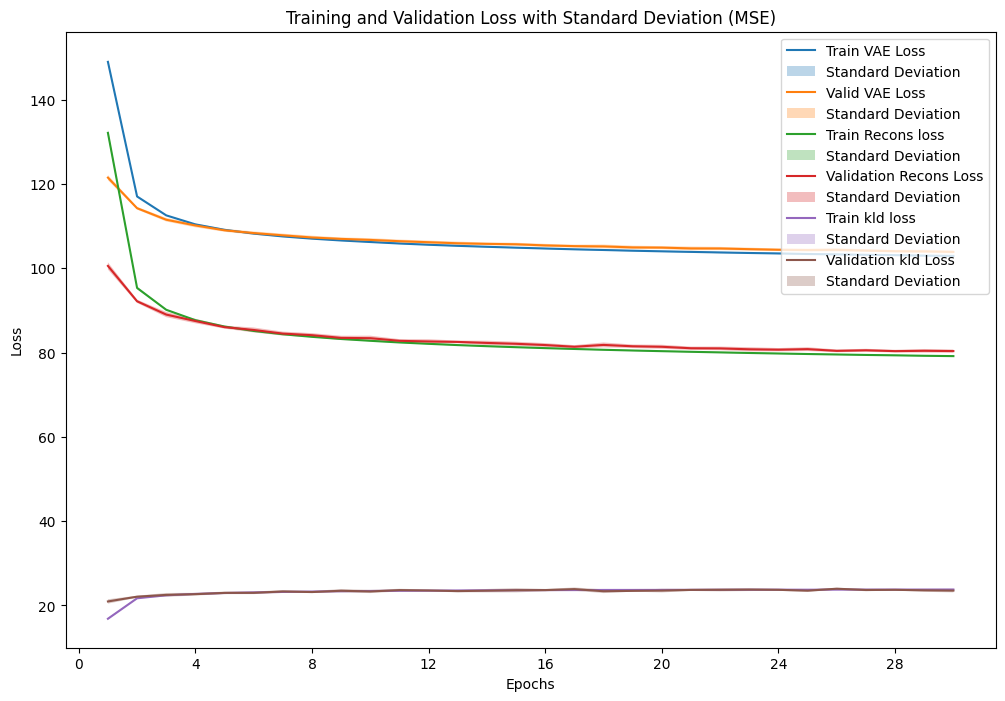

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_7 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_7_2 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_7_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_2['epochs'])
    VAE_plot_mean_std(result_data_4_7_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_2['epochs'])
    VAE_plot_mean_std(result_data_4_7_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_2['epochs'])
    VAE_plot_mean_std(result_data_4_7_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_2['epochs'])
    VAE_plot_mean_std(result_data_4_7_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_2['epochs'])
    VAE_plot_mean_std(result_data_4_7_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_7_2['valid_metrics'],
    result_data_4_7_2['test_metrics'],
    result_data_4_7_2['valid_result'],
    result_data_4_7_2['test_result'],
    result_data_4_7_2['recons_valid_result'],
    result_data_4_7_2['recons_test_result'],
    result_data_4_7_2['kld_valid_result'],
    result_data_4_7_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.013387           0.013117           103.912696     103.060419               80.383783         80.383783            23.528913      23.522442
Standard Deviation                 0.000156           0.000166             0.351215       0.203289                0.365176          0.365176             0.423826       0.414715

Detailed Evaluation Table:


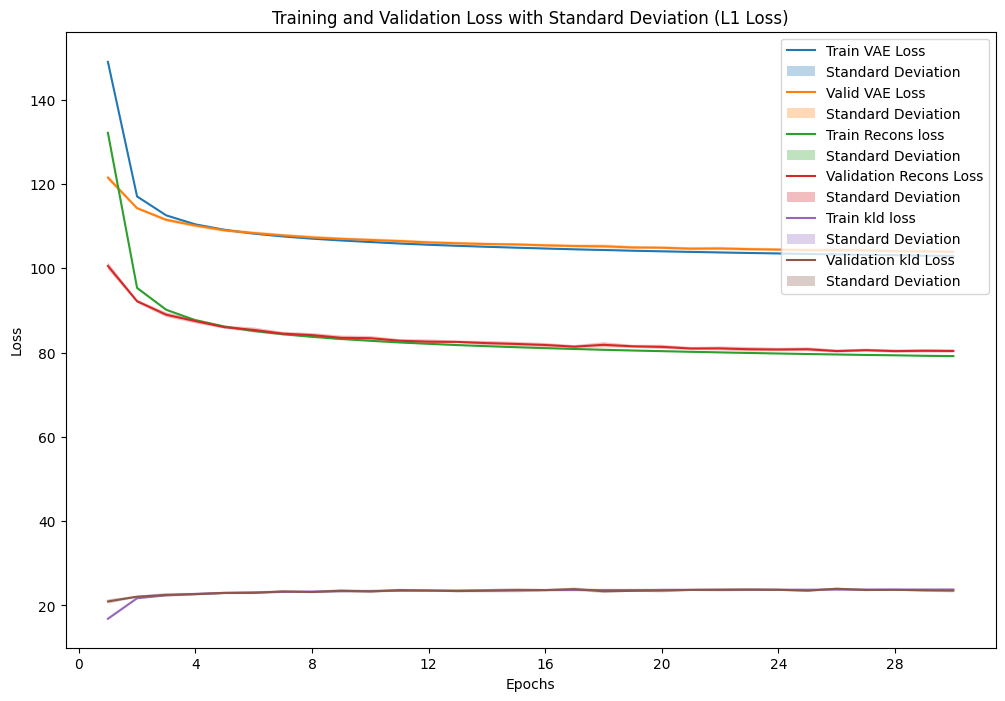

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_7 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_7_3 = VAE_plot_results(fold_results_4_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_7_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_7_3['epochs'])
    VAE_plot_mean_std(result_data_4_7_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_7_3['epochs'])
    VAE_plot_mean_std(result_data_4_7_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_7_3['epochs'])
    VAE_plot_mean_std(result_data_4_7_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_7_3['epochs'])
    VAE_plot_mean_std(result_data_4_7_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_7_3['epochs'])
    VAE_plot_mean_std(result_data_4_7_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_7_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_7_3['valid_metrics'],
    result_data_4_7_3['test_metrics'],
    result_data_4_7_3['valid_result'],
    result_data_4_7_3['test_result'],
    result_data_4_7_3['recons_valid_result'],
    result_data_4_7_3['recons_test_result'],
    result_data_4_7_3['kld_valid_result'],
    result_data_4_7_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.040873           0.040258           103.960624     103.071013               80.431711         80.431711            23.528913      23.522442
Standard Deviation                 0.000318           0.000320             0.332195       0.206688                0.342381          0.342381             0.423826       0.414715

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_7 = sum(p.numel() for p in models_4_7[0].parameters())
print(f"Number of parameters in the model: {total_params_4_7}")

Number of parameters in the model: 648016


### Sample new data using the decoder.

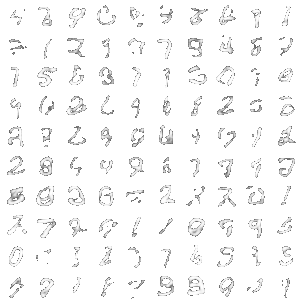

In [ ]:
sample(models_4_7[9],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_8 = 'VAE'
model_config_4_8 = {'D_x': 784, 'n_layers': 2, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_8, fold_results_4_8 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_8),
                                                model_config=model_config_4_8,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:152.804147, Training Recons Loss: 134.950993, Training KLD Loss: 17.853154
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.02224896077383706, 'L1 Loss': 0.060869351980534, 'BCE': 0.13031871751584906}, Validation VAE Loss: {'MSE': 124.84905307850939, 'L1 Loss': 124.84082786073076, 'BCE': 124.91960152159346}, Validation Recons Loss: {'MSE': 102.09932538296314, 'L1 Loss': 102.09110057100337, 'BCE': 102.16987439419361}, Validation KLD Loss: {'MSE': 22.749727715837196, 'L1 Loss': 22.749727715837196, 'BCE': 22.749727715837196}
Train Fold/Epoch: 1/2, Training Loss:118.797729, Training Recons Loss: 94.689282, Training KLD Loss: 24.108447
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.017551758831882095, 'L1 Loss': 0.05012964457273483, 'BCE': 0.11583034638711746}, Validation VAE Loss: {'MSE'

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_8.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_8.pkl')

In [ ]:
# Save models_3_8
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_8, f)

# Save fold_results_3_8
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_8, f)


## Visualizing reconstructions for all fold

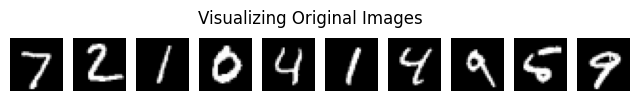

Visualizing reconstructions for fold 1


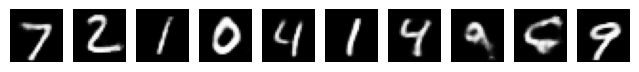

Visualizing reconstructions for fold 2


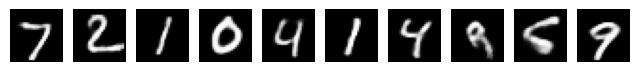

Visualizing reconstructions for fold 3


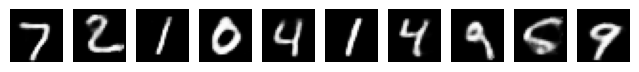

Visualizing reconstructions for fold 4


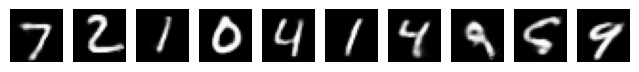

Visualizing reconstructions for fold 5


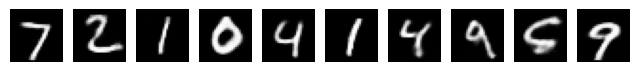

Visualizing reconstructions for fold 6


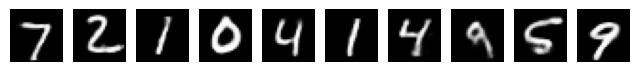

Visualizing reconstructions for fold 7


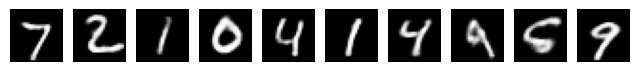

Visualizing reconstructions for fold 8


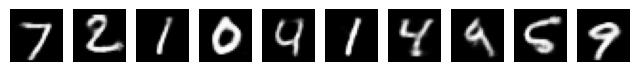

Visualizing reconstructions for fold 9


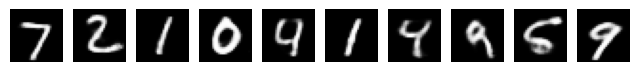

Visualizing reconstructions for fold 10


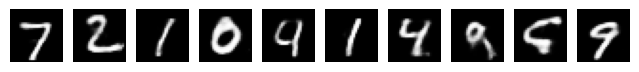

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_8.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_8 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_8):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

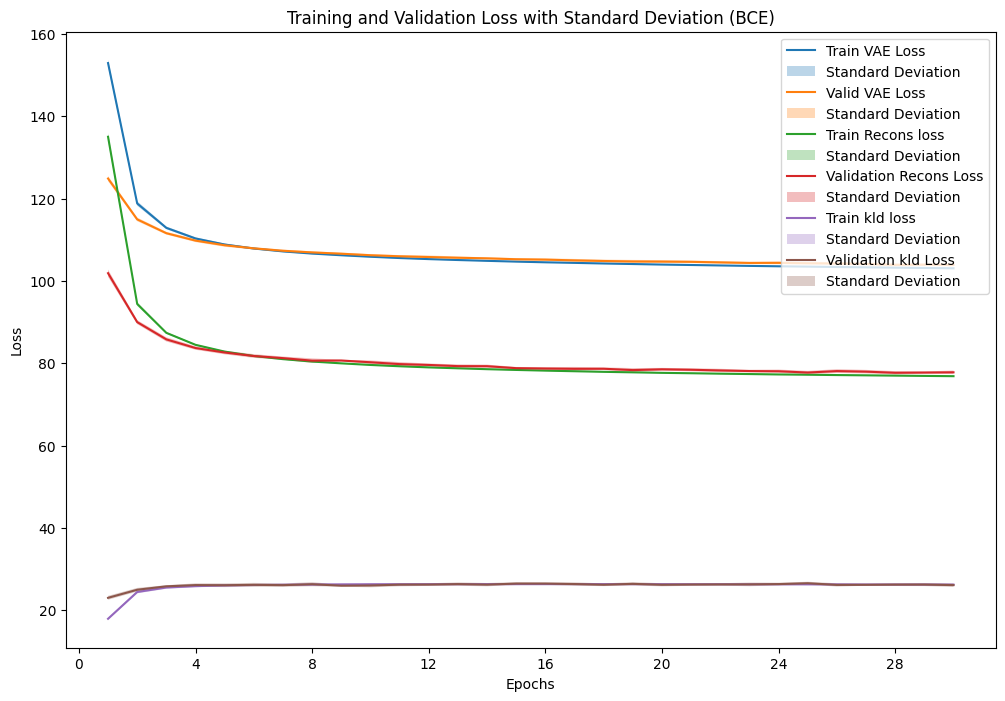

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_8 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_8_1 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_8_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_1['epochs'])
    VAE_plot_mean_std(result_data_4_8_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_1['epochs'])
    VAE_plot_mean_std(result_data_4_8_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_1['epochs'])
    VAE_plot_mean_std(result_data_4_8_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_1['epochs'])
    VAE_plot_mean_std(result_data_4_8_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_1['epochs'])
    VAE_plot_mean_std(result_data_4_8_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_8_1['valid_metrics'],
    result_data_4_8_1['test_metrics'],
    result_data_4_8_1['valid_result'],
    result_data_4_8_1['test_result'],
    result_data_4_8_1['recons_valid_result'],
    result_data_4_8_1['recons_test_result'],
    result_data_4_8_1['kld_valid_result'],
    result_data_4_8_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.099259           0.098212           103.909089     103.043083               77.819030         77.819030            26.090059      26.045129
Standard Deviation                 0.000571           0.000483             0.348376       0.110887                0.447325          0.447325             0.441424       0.413106

Detailed Evaluation Table:


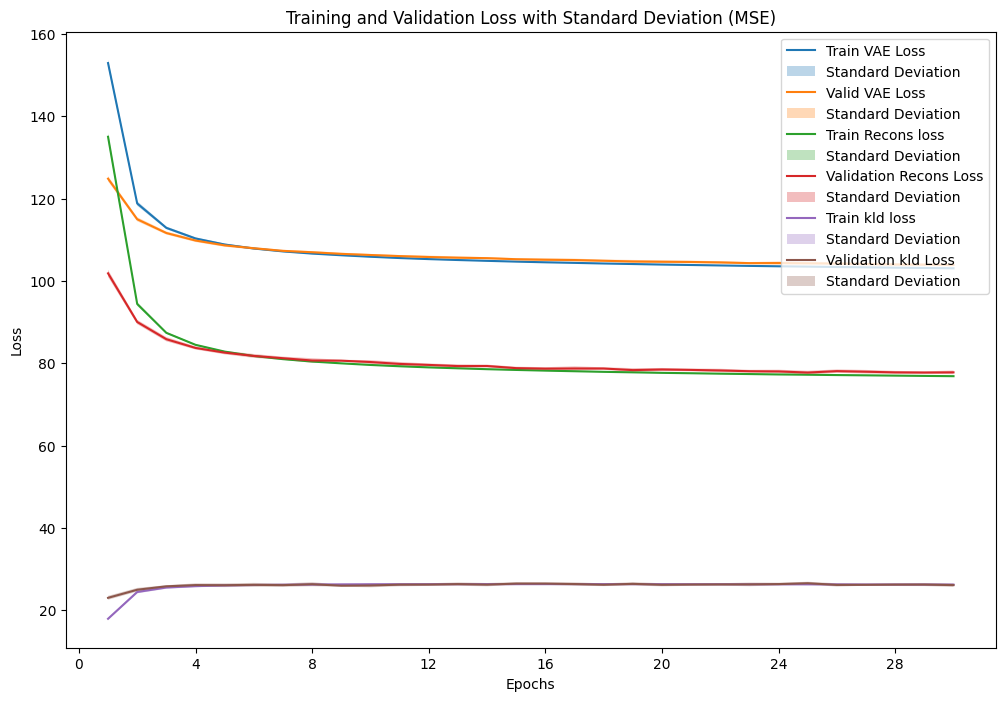

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_8 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_8_2 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_8_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_2['epochs'])
    VAE_plot_mean_std(result_data_4_8_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_2['epochs'])
    VAE_plot_mean_std(result_data_4_8_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_2['epochs'])
    VAE_plot_mean_std(result_data_4_8_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_2['epochs'])
    VAE_plot_mean_std(result_data_4_8_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_2['epochs'])
    VAE_plot_mean_std(result_data_4_8_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_8_2['valid_metrics'],
    result_data_4_8_2['test_metrics'],
    result_data_4_8_2['valid_result'],
    result_data_4_8_2['test_result'],
    result_data_4_8_2['recons_valid_result'],
    result_data_4_8_2['recons_test_result'],
    result_data_4_8_2['kld_valid_result'],
    result_data_4_8_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.012314           0.012056           103.881718     103.012117               77.791659         77.791659            26.090059      26.045129
Standard Deviation                 0.000160           0.000157             0.385496       0.158567                0.459667          0.459667             0.441424       0.413106

Detailed Evaluation Table:


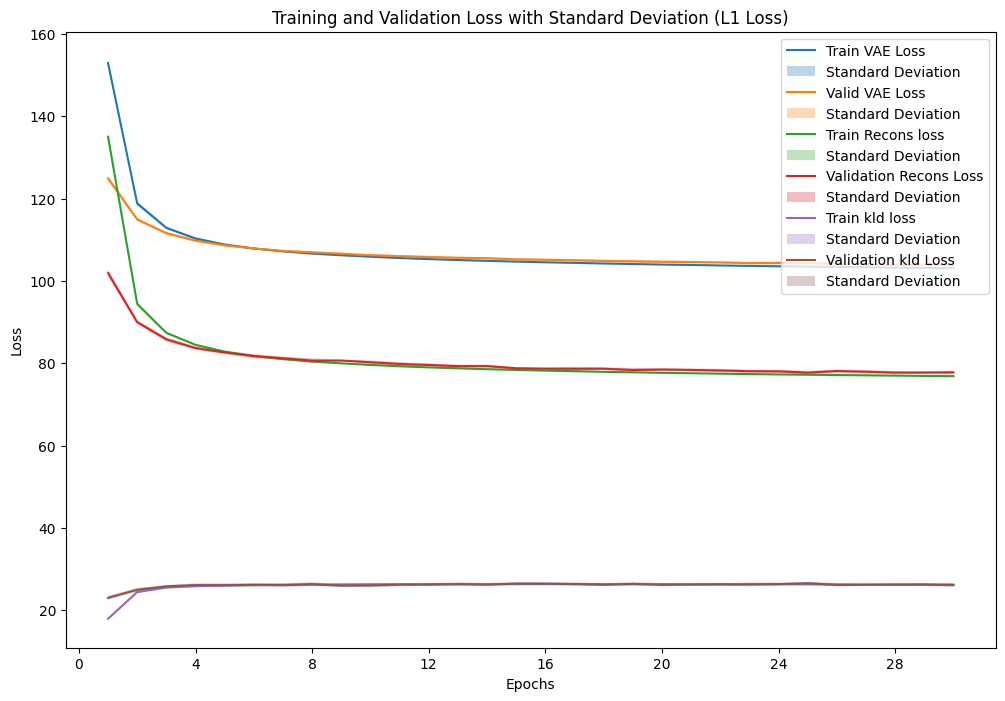

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_8 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_8_3 = VAE_plot_results(fold_results_4_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_8_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_8_3['epochs'])
    VAE_plot_mean_std(result_data_4_8_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_8_3['epochs'])
    VAE_plot_mean_std(result_data_4_8_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_8_3['epochs'])
    VAE_plot_mean_std(result_data_4_8_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_8_3['epochs'])
    VAE_plot_mean_std(result_data_4_8_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_8_3['epochs'])
    VAE_plot_mean_std(result_data_4_8_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_8_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_8_3['valid_metrics'],
    result_data_4_8_3['test_metrics'],
    result_data_4_8_3['valid_result'],
    result_data_4_8_3['test_result'],
    result_data_4_8_3['recons_valid_result'],
    result_data_4_8_3['recons_test_result'],
    result_data_4_8_3['kld_valid_result'],
    result_data_4_8_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.038639           0.038055           103.909143     103.007046               77.819084         77.819084            26.090059      26.045129
Standard Deviation                 0.000315           0.000304             0.341396       0.127337                0.432241          0.432241             0.441424       0.413106

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_8 = sum(p.numel() for p in models_4_8[0].parameters())
print(f"Number of parameters in the model: {total_params_4_8}")

Number of parameters in the model: 680576


### Sample new data using the decoder.

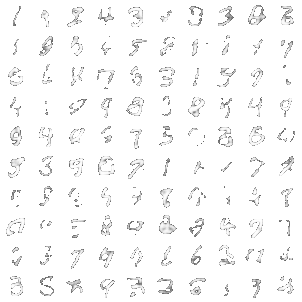

In [ ]:
sample(models_4_8[8],D_z=32)

### Experiment 2.4 : VAE with 2 layer

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_4_9 = 'VAE'
model_config_4_9 = {'D_x': 784, 'n_layers': 2, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_4_9, fold_results_4_9 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_4_9),
                                                model_config=model_config_4_9,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:156.343014, Training Recons Loss: 138.026495, Training KLD Loss: 18.316519
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.023831187866311124, 'L1 Loss': 0.06386479604592983, 'BCE': 0.13466759192499708}, Validation VAE Loss: {'MSE': 129.0422083266238, 'L1 Loss': 129.09138870239258, 'BCE': 128.8728495658712}, Validation Recons Loss: {'MSE': 105.7487512953738, 'L1 Loss': 105.79793223928898, 'BCE': 105.579392615785}, Validation KLD Loss: {'MSE': 23.293456523976428, 'L1 Loss': 23.293456523976428, 'BCE': 23.293456523976428}
Train Fold/Epoch: 1/2, Training Loss:121.444204, Training Recons Loss: 96.975268, Training KLD Loss: 24.468937
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.017875104845362776, 'L1 Loss': 0.05100540111356593, 'BCE': 0.11653745134777212}, Validation VAE Loss: {'MSE': 

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1/experience_1_2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_4_9.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_4_9.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_4_9, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_4_9, f)


## Visualizing reconstructions for all fold

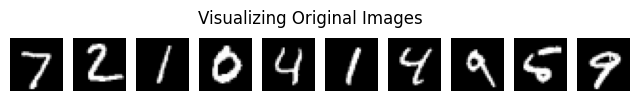

Visualizing reconstructions for fold 1


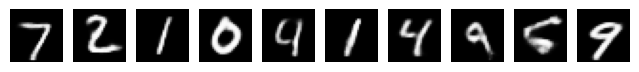

Visualizing reconstructions for fold 2


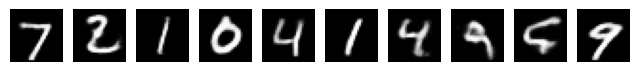

Visualizing reconstructions for fold 3


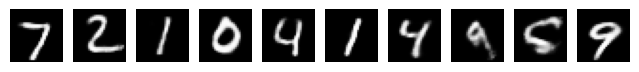

Visualizing reconstructions for fold 4


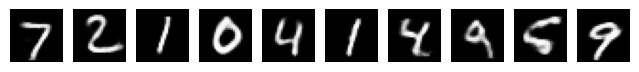

Visualizing reconstructions for fold 5


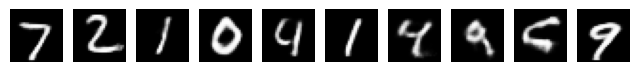

Visualizing reconstructions for fold 6


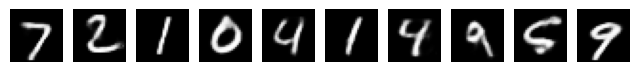

Visualizing reconstructions for fold 7


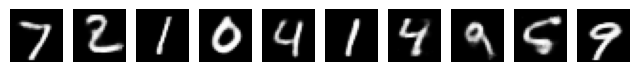

Visualizing reconstructions for fold 8


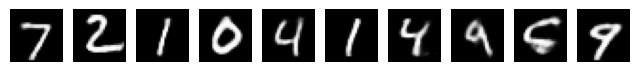

Visualizing reconstructions for fold 9


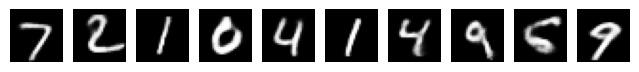

Visualizing reconstructions for fold 10


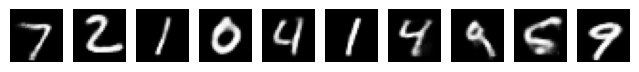

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'models_4_9.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_4_9 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_4_9):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

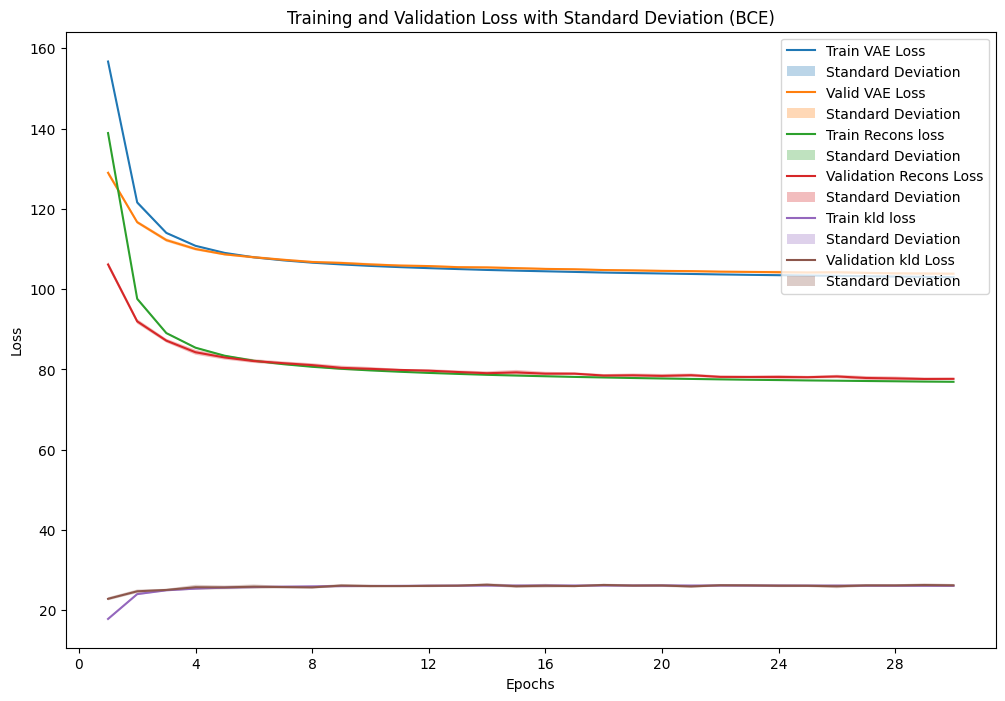

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_9 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_4_9_1 = VAE_plot_results(fold_results_4_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_9_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_9_1['epochs'])
    VAE_plot_mean_std(result_data_4_9_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_9_1['epochs'])
    VAE_plot_mean_std(result_data_4_9_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_9_1['epochs'])
    VAE_plot_mean_std(result_data_4_9_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_9_1['epochs'])
    VAE_plot_mean_std(result_data_4_9_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_9_1['epochs'])
    VAE_plot_mean_std(result_data_4_9_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_9_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_9_1['valid_metrics'],
    result_data_4_9_1['test_metrics'],
    result_data_4_9_1['valid_result'],
    result_data_4_9_1['test_result'],
    result_data_4_9_1['recons_valid_result'],
    result_data_4_9_1['recons_test_result'],
    result_data_4_9_1['kld_valid_result'],
    result_data_4_9_1['kld_test_result']
)


Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.099005           0.098007           103.820516     102.985605               77.620156         77.620156            26.200360      26.148071
Standard Deviation                 0.000345           0.000397             0.227537       0.114578                0.270806          0.270806             0.337109       0.358342

Detailed Evaluation Table:


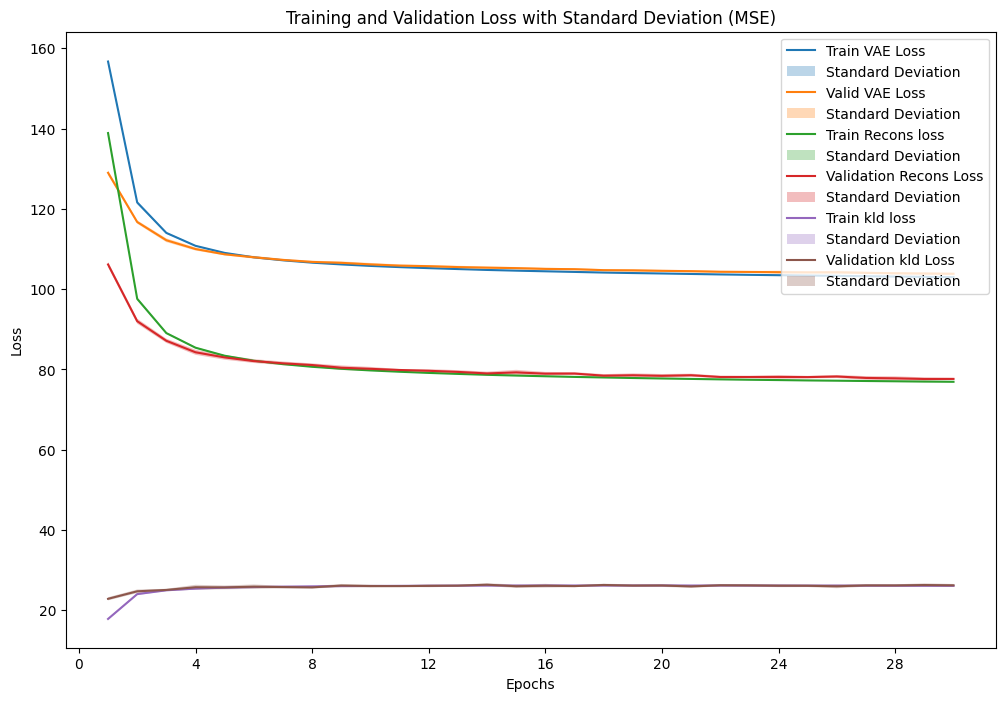

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_9 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_4_9_2 = VAE_plot_results(fold_results_4_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_9_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_9_2['epochs'])
    VAE_plot_mean_std(result_data_4_9_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_9_2['epochs'])
    VAE_plot_mean_std(result_data_4_9_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_9_2['epochs'])
    VAE_plot_mean_std(result_data_4_9_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_9_2['epochs'])
    VAE_plot_mean_std(result_data_4_9_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_9_2['epochs'])
    VAE_plot_mean_std(result_data_4_9_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_9_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_9_2['valid_metrics'],
    result_data_4_9_2['test_metrics'],
    result_data_4_9_2['valid_result'],
    result_data_4_9_2['test_result'],
    result_data_4_9_2['recons_valid_result'],
    result_data_4_9_2['recons_test_result'],
    result_data_4_9_2['kld_valid_result'],
    result_data_4_9_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.012242           0.012013           103.809190     103.010400               77.608831         77.608831            26.200360      26.148071
Standard Deviation                 0.000110           0.000145             0.242789       0.124825                0.226304          0.226304             0.337109       0.358342

Detailed Evaluation Table:


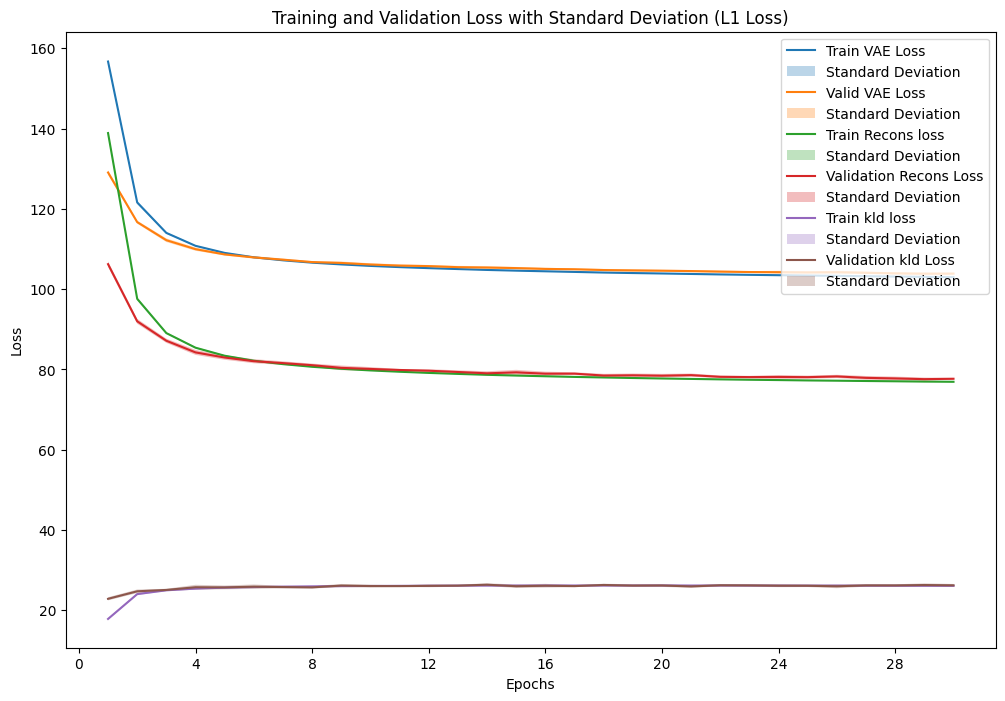

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1/experience_1_2/'
file_path = os.path.join(directory, 'fold_results_4_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_4_9 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_4_9_3 = VAE_plot_results(fold_results_4_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_4_9_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_4_9_3['epochs'])
    VAE_plot_mean_std(result_data_4_9_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_4_9_3['epochs'])
    VAE_plot_mean_std(result_data_4_9_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_4_9_3['epochs'])
    VAE_plot_mean_std(result_data_4_9_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_4_9_3['epochs'])
    VAE_plot_mean_std(result_data_4_9_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_4_9_3['epochs'])
    VAE_plot_mean_std(result_data_4_9_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_4_9_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_4_9_3['valid_metrics'],
    result_data_4_9_3['test_metrics'],
    result_data_4_9_3['valid_result'],
    result_data_4_9_3['test_result'],
    result_data_4_9_3['recons_valid_result'],
    result_data_4_9_3['recons_test_result'],
    result_data_4_9_3['kld_valid_result'],
    result_data_4_9_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.038508           0.038012           103.807415     103.014915               77.607055         77.607055            26.200360      26.148071
Standard Deviation                 0.000252           0.000284             0.249847       0.145228                0.274952          0.274952             0.337109       0.358342

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_4_9 = sum(p.numel() for p in models_4_9[0].parameters())
print(f"Number of parameters in the model: {total_params_4_9}")

Number of parameters in the model: 748000


### Sample new data using the decoder.

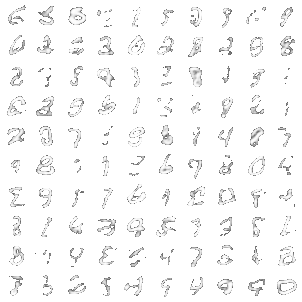

In [ ]:
sample(models_4_9[8],D_z=64)

# Table

In [ ]:
def create_dataframe(result_data, total_params_list, n_layer, dz_values):
    models_count = len(result_data)

    models = [''] * models_count
    vae_validation = [''] * models_count
    vae_testing = [''] * models_count
    total_params_per_model = [''] * models_count

    for i in range(models_count):
        mean_valid_metrics_loss = np.mean(result_data[i]['valid_metrics'])
        std_valid_metrics_loss = np.std(result_data[i]['valid_metrics'])
        mean_test_metrics_loss = np.mean(result_data[i]['test_metrics'])
        std_test_metrics_loss = np.std(result_data[i]['test_metrics'])

        models[i] = f"$D_x$: 784, $n_{{layers}}$: {n_layer[i]}, $D_z$: {dz_values[i]}"
        vae_validation[i] = f"{mean_valid_metrics_loss:.6f} ± {std_valid_metrics_loss:.6f}"
        vae_testing[i] = f"{mean_test_metrics_loss:.6f} ± {std_test_metrics_loss:.6f}"
        total_params_per_model[i] = total_params_list[i] if i < len(total_params_list) else ''

    data = pd.DataFrame({
        'Models': models,
        'VAE Validation': vae_validation,
        'VAE Testing': vae_testing,
        'Number of Parameters': total_params_per_model
    })

    return data

result_data = [
    result_data_4_1_1, result_data_4_1_2, result_data_4_1_3,
    result_data_4_2_1, result_data_4_2_2, result_data_4_2_3,
    result_data_4_3_1, result_data_4_3_2, result_data_4_3_3,
    result_data_4_4_1, result_data_4_4_2, result_data_4_4_3,
    result_data_4_6_1, result_data_4_6_2, result_data_4_6_3,
    result_data_4_7_1, result_data_4_7_2, result_data_4_7_3,
    result_data_4_8_1, result_data_4_8_2, result_data_4_8_3,
    result_data_4_9_1, result_data_4_9_2, result_data_4_9_3
]
total_params = ['', total_params_4_1, '',
                '', total_params_4_2, '',
                '', total_params_4_3, '',
                '', total_params_4_4, '',
                '', total_params_4_6,'',
                '', total_params_4_7,'',
                '', total_params_4_8,'',
                '', total_params_4_9,'']
n_layer = [1] * 12 + [2] * 12  # 12 models with n_layers = 1 and 12 models with n_layers = 2
dz_values = [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3 + [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3 # 12 models with D_z = 1 and 12 models with D_z = 2
data = create_dataframe(result_data, total_params, n_layer, dz_values)

# Convert dataframe to LaTeX and add \hline after each first row and after the first three rows
latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")
latex_output = "\\begin{table}\n\\begin{center}\n" + latex_output + "\\caption{Training VAE with BCE table.}\n\\label{tab:table1}\n\\end{center}\n\\end{table}"
latex_output = latex_output.replace('\\toprule', '\\toprule\n\\hline', 1)  # add after first row
latex_output = latex_output.replace('\\end{tabular}', '\\hline\n\\end{tabular}', -1)  # add \hline at the end
print(latex_output)


\begin{table}
\begin{center}
\begin{tabular}{|c|c|c|c|}
\toprule
\hline
                                Models &      VAE Validation &         VAE Testing & Number of Parameters \\
\midrule
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.227533 ± 0.001056 & 0.226507 ± 0.000240 &                      \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.056011 ± 0.000277 & 0.055805 ± 0.000051 &                 5492 \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.127180 ± 0.001032 & 0.127095 ± 0.000761 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.138679 ± 0.000635 & 0.136706 ± 0.000310 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.024833 ± 0.000180 & 0.024262 ± 0.000119 &                38448 \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.065220 ± 0.000340 & 0.064257 ± 0.000332 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.114780 ± 0.000327 & 0.113015 ± 0.000269 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.0169

<ipython-input-106-2927a3a21d12>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")


$$\textbf{METRIC} : BCE$$

$$
\begin{array}{c|S|r}
{\textbf{Model}}{\textbf{}} & \textbf{ $β =0.02$-VAE Validadion} & \textbf{$β =0.02$-Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1$-VAE Validation} & \textbf{$β =1$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1.5$-VAE Validation} & \textbf{$β =1.5$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =10$-VAE Validation} & \textbf{$β =10$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{VAE Number of Parameters} \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 2 & 0.226275 \pm 0.001036 & 0.225166 \pm 0.000662 & No & 0.227426 \pm 0.000807 & 0.226353 \pm 0.000118 & No &  0.228052 \pm  0.000902 & 0.226930 \pm 0.000231 & No & 0.239047 \pm 0.001129 & 0.238689 \pm 0.000748  & No & 5492\\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 16 & 0.127615 \pm  0.000348 & 0.125684 \pm 0.000077 & No & 0.138684 \pm 0.000436 & 0.136730 \pm 0.000278 & No & 0.144070 \pm 0.000446 & 0.142173 \pm 0.000265 & No &  0.138747 \pm 0.000398 & 0.136760 \pm 0.000257 & No & 38448 \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 32 & 0.093204 \pm 0.000321 & 0.091596 \pm 0.000083 & No &  0.114784 \pm 0.000397 & 0.113037 \pm 0.000186 & No & 0.125249 \pm 0.000701& 0.123467 \pm 0.000630  & No & 0.221198 \pm 0.000950 & 0.220252 \pm 0.000617 & No & 76112\\
\hline \\
\textbf{D_x: 784, n_{layers}: 1, D_z: 64} & \textbf{ 0.073867} \pm \textbf{0.000287} & \textbf{0.072968} \pm \textbf{0.000105} & No & \textbf{0.109525} \pm \textbf{0.000464} & \textbf{0.108042} \pm \textbf{0.000376} & No & \textbf{0.123874} \pm \textbf{0.000349} & \textbf{0.122243} \pm \textbf{0.000522} & \textbf{No} & \textbf{0.221015} \pm \textbf{0.000921} & \textbf{0.220111} \pm 0.000803 & \textbf{No} & \textbf{151440}\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 2 & 0.181346 \pm  0.001216 &  0.181094 \pm 0.000885 & Yes &  0.184722 \pm 0.001426 & 0.184430 \pm 0.001378 & Yes & 0.185251 \pm  0.001356  & 0.185076 \pm 0.001369 & Yes & 0.204847 \pm 0.001291 & 0.204616 \pm 0.001091  & No & 620156\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 16 & 0.088940 \pm 0.000316 & 0.087978 \pm 0.000131 & Yes &  0.102318 \pm  0.000711 & 0.101194 \pm 0.000515 & Yes & 0.109030 \pm 0.000502 & 0.107935 \pm 0.000414 & Yes & 0.185056 \pm 0.000977 & 0.184375\pm 0.000760  & No & 648016\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 32 & 0.075699 \pm 0.000266 & 0.074949 \pm 0.000093 & Yes & 0.098988 \pm 0.000679 & 0.097934 \pm 0.000546 & Yes &  0.107636 \pm 0.000740 & 0.106483 \pm 0.000663 & Yes & 0.185831 \pm 0.001297 &  0.185198 \pm 0.000978  & No & 680576\\
\hline \\
\color{red}{D_x: 784, n_{layers}: 2, D_z: 64} & \color{red}{0.069187\pm 0.000225} & \color{red}{0.068637 \pm 0.000056 } & \color{red}{Yes} & \color{red}{ 0.099061 \pm 0.000934} & \color{red}{0.098014 \pm 0.000880} & \color{red}{Yes} & \color{red}{0.107992 \pm 0.000326} & \color{red}{0.106826 \pm 0.000498} & \color{red}{Yes} & 0.188006 \pm 0.000799 & 0.187317 \pm  0.001166 & \color{red}{No} & \color{red}{748000} \\
\hline
\end{array}
$$